In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.formula.api as smf

#sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier

#imblearn to balance training data
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from collections import Counter

# XGB
import xgboost as xgb
from xgboost import XGBClassifier
xgb.set_config(verbosity=0) # to supress warnings

# shap
import shap

#joblib to save trained models
import joblib

#import warnings
#warnings.filterwarnings('ignore')

# Show pipelines as interactive diagram
from sklearn import set_config; set_config(display='diagram')

In [2]:
# Set random seed for reproducibility reasons
np.random.seed(42)

In order to run the notebook smoothly you should make sure to use the same version as listed below. 👇 <br>
Deviation from these versions might lead to error messages during the execution of the code. 

In [3]:
print("Installed/ Used versions:")
print("python: 3.8.6")
from sklearn import __version__
print("sklearn:", __version__)
from imblearn import __version__
print("imblearn:", __version__)
print("shap:", shap.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
from matplotlib import __version__
print("matplotlib:", __version__)
print("seaborn:", sns.__version__)
print("xgb:", xgb.__version__)
print("joblib:", joblib.__version__)

Installed/ Used versions:
python: 3.8.6
sklearn: 1.0.1
imblearn: 0.8.1
shap: 0.40.0
numpy: 1.19.5
pandas: 1.2.5
matplotlib: 3.4.2
seaborn: 0.11.1
xgb: 1.4.2
joblib: 1.0.1


# Introduction to ProPublica's analysis

**General information about ProPublica's dataset and COMPAS:**
- ProPublica obtained a dataset of pretrial defendants and probationers from Broward County, FL, who had been assessed with the COMPAS screening system between January 1, 2013, and December 31, 2014.
- COMPAS is the name of an algorithm which was programmed and sold by XXX to assess among others the probability of recidivism for persons facing trial  
- COMPAS recidivism risk scores are based on a defendant’s answers to the COMPAS screening survey. The survey is completed by pre-trial services in cooperation with the defendant after his or her arrest. 
- The COMPAS survey, at least in the ProPublica data, is typically administered the same day or the day after a person was arrested.
- For the more than 11 thousand pretrial defendants in this dataset, ProPublica then collected data on future arrests through the end of March 2016, in order to study how accurately the COMPAS score predicts recidivism for these defendants (Link articles)
- ProPublica collected the data from multiple sources for its study and created a database. From that database, it constructed various sub-datasets that merged and calculated various important features. For example, an indicator for a re-arrest for a new crime within two years of the original one. ProPublica then exported these sub-datasets into .csv files. These files were named by ProPublica `compas-scores.csv` and `compas-scores-two-years.csv`. 
- The first file `compas-scores.csv` contains the full dataset of pretrial defendants that ProPublica obtained from the Broward County Sheriff’s Office. This file contains 11,757 people.
- The second file `compas-scores-two-years.csv` is a file that ProPublica created for the purpose of studying two-year general recidivism. The term general recidivism is used to distinguish it from the smaller subset of violent recidivism. General recidivism includes both violent and non-violent offenses. 
- The two-year general recidivism file contains 7,214 people.

**Scope of our project**:<br>
For our project we chose to the following two prediction tasks: 
1) Classification: Prediction of general recidivism within two years after COMPAS assessment<br>
2) Regression: Prediction of the COMPAS decile score for general recidivism
 
> 💡 Please note that we created two separate notebooks for this project:
>1) `Classification_report`<br>
>2) `Regression_report`<br>

<br>
This notebook (`Classification_report`) can be considered as the *main* notebook which includes (apart from the Classification modeling journey) also chapters for the analysis of ProPublica's data and the fairness discussion. The second notebook (`Regression_report`) only contains the modeling journey for the regression task.

**Used dataset**:
- For our analysis and modeling we solely used the constructed `compas-scores-two-years.csv` file from ProPublica as it already contains the most important characteristics for each defendant as well as our target variables for both the regression and the classification task
- Even though the created database includes some more data which could have been used to create features we decided against using it for two main reasons: <br>
    1) Firstly we see a big room for errors, as one would have to carefully recreate ProPublicas queries and make sure not to include any data from after the COMPAS screening into the feature engineering <br>
    2) Secondly it was not always clear what the different columns represent

In [4]:
# Load data and transform date columns to "datetime"
df = pd.read_csv("../../data-ProPublica/compas-scores-two-years.csv", parse_dates=["c_jail_in", "c_jail_out", "compas_screening_date", 'screening_date',
 'v_screening_date'])
df.shape #Check shape

(7214, 53)

## Fix processing errors in ProPublica's dataset

Before we started with the analysis of the data and the recreation of some of ProPublicas analysis we first had to fix some data quality issues of ProPublica's dataset

### Examine distribution of defendants across COMPAS screening dates

ProPublica claims that the constructed csv files is already filtered for defendants who either have reoffened within two years after the COMPAS screening or had at least two years outside of a correctional facility:

> We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

We decided to have a closer look, whether the data is really already filtered as described

- To construct their two-year recidivism sub-datasets, ProPublica presumably wanted to keep people observed
for at least two years at the end of the time window for which ProPublica collected criminal history data, on
April 1, 2016. Therefore, we should not have expected to see anybody in the two-year datasets with COMPAS
screening (or arrest) dates after April 1, 2014 (i.e. less than two years prior to ProPublica’s data collection). 
- However, as we will see further below, there are many people in ProPublica’s two-year recidivism datasets
who do indeed have COMPAS screening dates after this potential cutoff, all the way through December 31,
2014, which is the end date of the original database.
- Taking a closer look at these datasets, we see that ProPublica correctly dropped non-recidivists with COMPAS
screening dates post 4/1/2014. However, it kept people with COMPAS screening dates after 4/1/2014 if they
recidivated. 

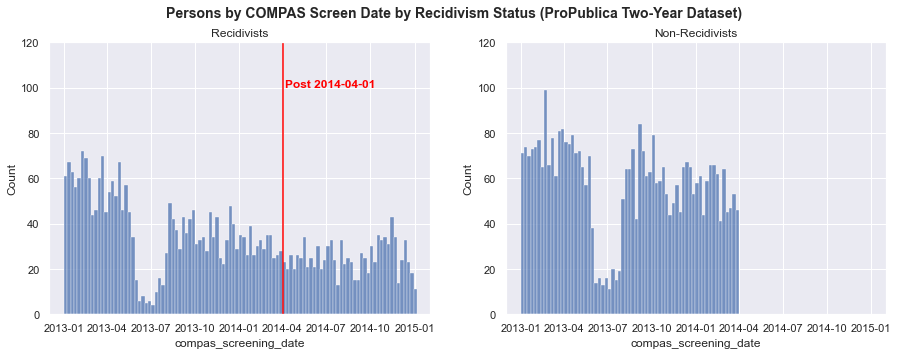

In [5]:
# Assess distribution of defendants across COMPAS screening date
sns.set_theme()

fig, axes = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Persons by COMPAS Screen Date by Recidivism Status (ProPublica Two-Year Dataset)", fontsize=14, fontweight="bold")
plt.setp(axes, ylim=(0,120), xlim=[datetime.date(2012, 12, 1), datetime.date(2015, 2, 1)])

df_recid = df[df["is_recid"]==1] # Filter df for recidivists
df_nonrecid = df[df["is_recid"]==0] # Filter df for non-recidivists

#Create plot for recidivists
sns.histplot(x="compas_screening_date", data=df_recid, ax=axes[0], binwidth=7)
axes[0].axvline(datetime.date(2014, 4, 1), color="red")
axes[0].text(datetime.date(2014, 4, 7),100,'Post 2014-04-01', color="red", fontweight="bold")
axes[0].set_title("Recidivists")

#Create plot for non-recidivists
sns.histplot(x="compas_screening_date", data=df_nonrecid, ax=axes[1], binwidth=7)
axes[1].set_title("Non-Recidivists");

We can see that ProPublica made a substantial data processing error when it created the dataset. It **failed to implement a two-year sample cutoff for recidivists** in the data (whereas it did implement such a sample cutoff for non-recidivists). As a result, ProPublica's dataset contains incorrectly a disproportionate share of recidivists. This mistake leads to a biased `compas-scores-two-years.csv` dataset, with artificially high recidivism rates. <br>

After noticing the processing error we did some research to validate our findings. Here we found out that we are not the first who noticed ProPublica's mistake<br>

Below you can find the links to the paper and GitHub repository of the author:<br>
👉 [Paper](https://arxiv.org/pdf/1906.04711.pdf) <br>
👉 [GitHub repository](https://github.com/mbarenstein/ProPublica_COMPAS_Data_Revisited)<br> 

The graphs shown above are inspired by this paper. 

We implemented the sample cutoff at 2014-04-01 for recidivists before continuing with our analysis:

In [6]:
#Implement cutoff after 4/1/2014
df_corrected = df[df["compas_screening_date"]<="2014-04-01"]

print("No rows in original dataset:", df.shape[0])
print("No rows in corrected dataset:", df_corrected.shape[0])

No rows in original dataset: 7214
No rows in corrected dataset: 6216


As shown above, this drops 998 recidivists who ProPublica incorrectly kept in the two-year (general recidivism) dataset. They are dropped because they have COMPAS screen dates post-April 1, 2014.

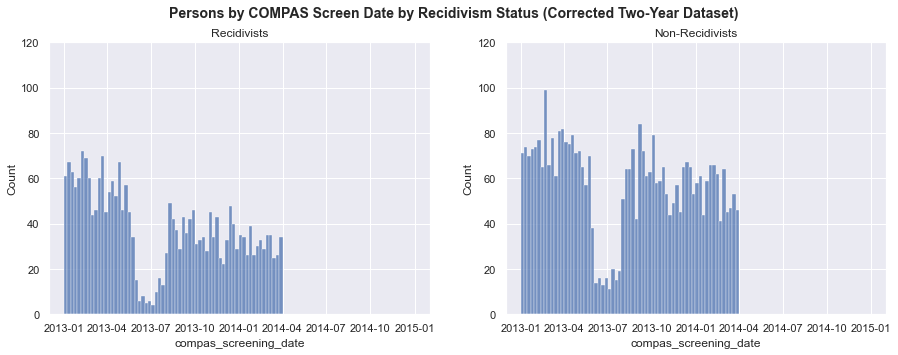

In [7]:
#Recreate charts from above to visually confirm results
fig_corr, axes_corr = plt.subplots(1,2, figsize=(15,5))
fig_corr.suptitle("Persons by COMPAS Screen Date by Recidivism Status (Corrected Two-Year Dataset)", fontsize=14, fontweight="bold")
plt.setp(axes_corr, ylim=(0,120), xlim=[datetime.date(2012, 12, 1), datetime.date(2015, 2, 1)])

df_corr_recid = df_corrected[df_corrected["is_recid"]==1]
df_corr_nonrecid = df_corrected[df_corrected["is_recid"]==0]

sns.histplot(x="compas_screening_date", data=df_corr_recid, ax=axes_corr[0], binwidth=7)
axes_corr[0].set_title("Recidivists")

sns.histplot(x="compas_screening_date", data=df_corr_nonrecid, ax=axes_corr[1], binwidth=7)
axes_corr[1].set_title("Non-Recidivists");


Looks good. Let's continue with our analysis. 

## Remove duplicate columns

After implementing the cut-off we then had a closer look at the different columns of the two_years.csv file

In [8]:
# List all duplicated columns of df_corrected df  
(set(df_corrected.columns)-set(df_corrected.T.drop_duplicates().T.columns))|(set(df_corrected.columns)-set(df_corrected.T.drop_duplicates(keep="last").T.columns))

{'compas_screening_date',
 'decile_score',
 'decile_score.1',
 'priors_count',
 'priors_count.1',
 'screening_date',
 'v_screening_date'}

As we can see the df contains duplicated columns! For further analysis only one column will be kept per pair. The following columns will be dropped from the DataFrame: <br>
- `screening_date`
- `v_screening_date`
- `decile_score.1`
- `priors_count.1`

In [9]:
# drop columns
df_clean = df_corrected.drop(columns=['decile_score.1', 'screening_date', 'v_screening_date', 'priors_count.1'])

#Check shape of cleaned DataFrame
df_clean.shape

(6216, 49)

As a final step we exported the cleaned DataFrame as .csv for easier processing and modeling. The following line of code is commented out, as it only has to be created once.

In [10]:
#df_clean.to_csv("../../data-cleaned/compas-scores-two-years-clean", index=False)

## Recreation of ProPublica's analysis for general recidivism

Using the cleaned dataframe we then were able to recreate some of ProPublica's original analysis. However, since we dropped some rows, the numbers are not completly conform with the numbers published by ProPublica.

First we applied the same filters as used by ProPublica: 
>"However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility."

In [11]:
# Select columns of interest and store as new df
df = df_clean[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

# Filter rows as described by ProPublica
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O")
      ].dropna(subset=['score_text'])

df.shape

(5304, 13)

After applying the filters only 5304 defendants remain in the dataset

In the follwoing to chapters we recreated some parts from ProPublica's original analysis. Since our focus is on the general recidivism we only recreated these parts of their notebook. For the complete analysis please visit ProPublica's GitHub repository. 

### Demographic breakdown

Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [12]:
df["length_of_stay_days"] = (df.c_jail_out-df.c_jail_in).dt.days
np.round(df[["length_of_stay_days", "decile_score"]].corr()\
    .loc["length_of_stay_days","decile_score"],5)

0.21148

After filtering we have the following demographic breakdown:

In [13]:
df.age_cat.value_counts()

25 - 45            3031
Greater than 45    1165
Less than 25       1108
Name: age_cat, dtype: int64

In [14]:
(df.race.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

African-American    50.57%
Caucasian           34.48%
Hispanic             8.45%
Other                5.83%
Asian                0.51%
Native American      0.17%
Name: race, dtype: object

In [15]:
df.score_text.value_counts()

Low       3086
Medium    1329
High       889
Name: score_text, dtype: int64

In [16]:
pd.crosstab(df["sex"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,474,1,414,73,2,53
Male,2208,26,1415,375,7,256


In [17]:
df.sex.value_counts()

Male      4287
Female    1017
Name: sex, dtype: int64

In [18]:
(df.sex.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

Male      80.83%
Female    19.17%
Name: sex, dtype: object

In [19]:
no_recid = np.sum(df["two_year_recid"]==1)
print("Number of entries with two_year_recid:", no_recid)
print("% of entries with two_year_recid", np.round(no_recid/df.shape[0]*100,2))

Number of entries with two_year_recid: 1941
% of entries with two_year_recid 36.6


"Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants."

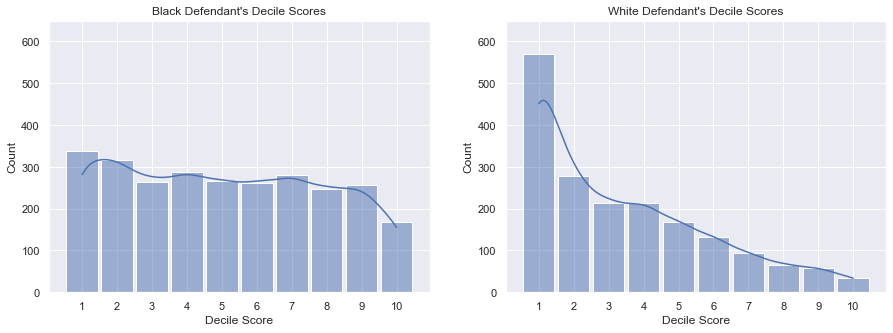

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["decile_score"]
scores_white = df[df["race"]=="Caucasian"]["decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Decile Scores");


In [21]:
pd.crosstab(df["decile_score"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,338,14,570,146,0,136
2,316,4,277,77,2,53
3,264,4,214,64,1,28
4,288,0,214,43,0,33
5,265,1,168,31,0,17
6,262,2,133,23,2,17
7,280,0,93,25,2,8
8,246,2,66,12,0,4
9,256,0,59,17,1,6


### Racial Bias in COMPAS

After filtering out bad rows, ProPublica assessed whether there is a significant difference in Compas scores between races. To do so they changed some variables into factors, and ran a logistic regression, comparing low scores to high scores (medium and high).

In [22]:
#Create df for Logistic regression model 
df_log = df[['sex', 'age_cat', 'race', 'priors_count',
             'c_charge_degree', 'two_year_recid', 'score_text']].copy()

# Combine Medium and High Risk score into one category
df_log["score_text"] = df_log.score_text.apply(lambda x: 0 if x=="Low" else 1)#.astype('category')

# Rename columns according to ProPublica
df_log.columns = ['gender_factor','age_factor','race_factor', 'priors_count',
                  'crime_factor', 'two_year_recid', 'score_factor']

In [23]:
# Create list of labels for Ordinal Encoder so that the order is identical to ProPublica
gender_labels = ["Male","Female"]
age_labels = ['25 - 45', 'Greater than 45', 'Less than 25']
race_labels = ['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']
crime_labels = ['F', 'M']

#Instantiate Ordinal Encoder
ord_encoder = OrdinalEncoder(categories=[gender_labels, age_labels, race_labels, crime_labels])

In [24]:
# Create encoded df
df_log_enc = df_log.copy()

# Encode features (statsmodels requires numerical features)
df_log_enc[['gender_factor', 'age_factor', 'race_factor', 'crime_factor']] = ord_encoder.fit_transform(
    df_log[['gender_factor', 'age_factor', 'race_factor', 'crime_factor']]) 


In [25]:
# Fit model
formula = "score_factor ~ C(gender_factor) + C(age_factor) + C(race_factor)+ priors_count + C(crime_factor) + two_year_recid"
model = smf.logit(formula=formula, data=df_log_enc).fit()

Optimization terminated successfully.
         Current function value: 0.496531
         Iterations 6


In [26]:
# Create summary table with correct label names 
result = model.summary(xname=["Intercept",
                     "gender_factorFemale", 
                     "age_factorGreater than 45", 
                     "age_factorLess than 25",
                     "race_factorAfrican-American",
                     "race_factorAsian",
                     "race_factorHispanic",
                     "race_factorNative American",
                     "race_factorOther",
                     "crime_factorM",
                     "priors_count",
                     "two_year_recid"])

result

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           score_factor   No. Observations:                 5304
Model:                          Logit   Df Residuals:                     5292
Method:                           MLE   Df Model:                           11
Date:                Sat, 05 Feb 2022   Pseudo R-squ.:                  0.2695
Time:                        14:10:59   Log-Likelihood:                -2633.6
converged:                       True   LL-Null:                       -3605.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.5589      0.084    -18.608      0.000      -1.723      -1.395
gender_factorFemale             0.2283      0.086      2.648      0.008       0.059       0.397
age_factorGreater than 45      -1.3775      0.107    -12.817      0.000      -1.588      -1.167
age_factorLess than 25          1.3626      0.083     16.510      0.000       1.201       1.524
race_factorAfrican-American     0.4886      0.075      6.491      0.000       0.341       0.636
race_factorAsian               -0.4219      0.544     -0.776      0.438      -1.487       0.643
race_factorHispanic            -0.3720      0.139     -2.682      0.007      -0.644      -0.100
race_factorNative American      1.3375      0.785      1.703      0.089      -0.202       2.877
race_factorOther               -0.7925      0.174     -4.542      0.000      -1.134      -0.450
crime_factorM                  -0.2829      0.072     -3.944      0.000      -0.424      -0.142
priors_count                    0.2689      0.012     22.112      0.000       0.245       0.293
two_year_recid                  0.6915      0.071      9.679      0.000       0.551       0.832
===============================================================================================
"""

Black defendants are 41% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [27]:
intercept_coef = model.params["Intercept"] #Coefficient (log-odds) for Caucasian man between 25 and 45 receiving a high risk score
african_american_coef = model.params["C(race_factor)[T.1.0]"] #Coefficient (decrease in log-odds relative to white man) for African American man between 25 and 45 (see ord_encoder.categories_)

control = np.exp(intercept_coef) / (1+ np.exp(intercept_coef)) # Probability? of white man between 25-45 to receive a higher score
np.exp(african_american_coef) / (1- control + (control *np.exp(african_american_coef))) # ?


1.469117004110728

In [28]:
odds_white = np.exp(intercept_coef) # odds of white man between 25-45 to receive a higher score
odds_black = np.exp(intercept_coef+african_american_coef) # odds of african-american man between 25-45 to receive a higher score

odds_black/odds_white #odds ratio of black man compared to white man receiving a higher risk score

#same as above (odds_white cancel out)
np.exp(african_american_coef)


1.6299826197540508

In [29]:
(np.exp(intercept_coef+african_american_coef)+np.exp(intercept_coef)) / (1+np.exp(-1.5589+0.4886)) #(odd black + odd white) / (1+odd black))

0.4120087699326899

Women are 20.3% more likely than men to get a higher score.

In [30]:
woman_coef = model.params["C(gender_factor)[T.1.0]"]

np.exp(woman_coef) / (1 - control + (control * np.exp(woman_coef)))

1.2028345874001927

In [31]:
odds_woman = np.exp(intercept_coef+woman_coef)

odds_woman/odds_white

1.2564495677130931

Most surprisingly, people under 25 are 2.6 times as likely to get a higher score as middle aged defendants.

In [32]:
young_coef = model.params["C(age_factor)[T.2.0]"]

np.exp(young_coef) / (1 - control + (control * np.exp(young_coef)))

2.595306273380915

We will come back to the discussion about fairness of the COMPAS model in the last chapter of this notebook. In the following chapters will focus on our modeling journey of trying to find a better performing model.

# Create dataframe for modeling


In [33]:
# Load cleaned df and recreate filters 
df = pd.read_csv("../../data-cleaned/compas-scores-two-years-clean.csv")
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
      ].dropna(subset=['score_text'])

## Select relevant columns

- Since most of the columns in the dataset describe charges after the initial COMPAS screening these columns can not be used as predictors. 
- Furthermore we compared the original questionaire for the COMPAS scoring with the data of our datasets: 
- From the X sections in the original questionaire we only have data about demographics, criminal history and current charges from the defendant. 

In [34]:
# Select columns of interest and store as new df
columns = ["id", "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_desc", #current charges
           "score_text", "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "r_charge_degree", "r_charge_desc", #commited crimes (general) within 2 years after COMPAS scoring (no feature for final model, but relevant for feature engineering)
           "two_year_recid"] #target for classification 
df_clean = df[columns]

In [35]:
# Drop duplicates (there are none, but for completness we introduce the step anyhow)
df_clean = df_clean.drop_duplicates()

## Check missing values and dtypes

In [36]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6215
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5304 non-null   int64 
 1   age              5304 non-null   int64 
 2   age_cat          5304 non-null   object
 3   sex              5304 non-null   object
 4   race             5304 non-null   object
 5   juv_fel_count    5304 non-null   int64 
 6   juv_misd_count   5304 non-null   int64 
 7   juv_other_count  5304 non-null   int64 
 8   priors_count     5304 non-null   int64 
 9   c_charge_degree  5304 non-null   object
 10  c_charge_desc    5299 non-null   object
 11  score_text       5304 non-null   object
 12  decile_score     5304 non-null   int64 
 13  r_charge_degree  2122 non-null   object
 14  r_charge_desc    2095 non-null   object
 15  two_year_recid   5304 non-null   int64 
dtypes: int64(8), object(8)
memory usage: 704.4+ KB


- Some columns contain null values, but out of these only `c_charge_desc`will be relevant for modeling, since the other columns contain data which was generated after the COMPAS screening, an thus can not be used 
- The imputing of missing values will be performed during the preprocessing 

## Check outliers

In [37]:
df_clean[["age", 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']].describe()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,5304.000000,5304.000000,5304.000000,5304.000000,5304.000000
mean,34.953431,0.052036,0.088047,0.101433,2.993590
std,11.817771,0.382938,0.511951,0.448231,4.458153
min,19.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,0.000000,0.000000,0.000000,1.000000
75%,43.000000,0.000000,0.000000,0.000000,4.000000
max,96.000000,10.000000,13.000000,9.000000,37.000000


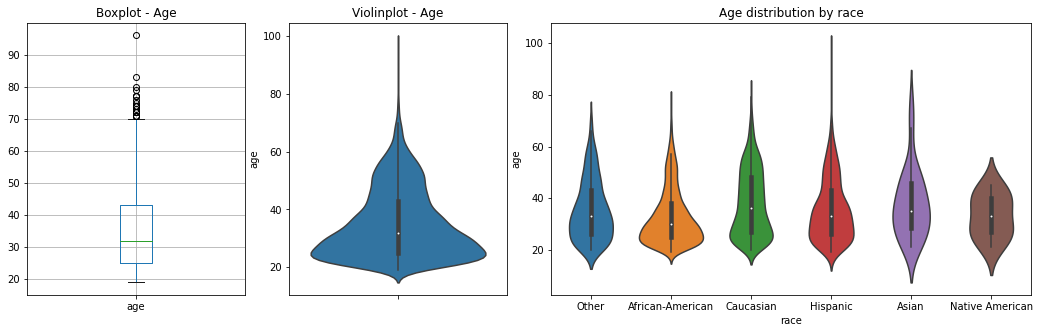

In [38]:
# Check age distribution and outliers
sns.reset_orig()
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1,4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2:])

df_clean[["age"]].boxplot(ax=ax1) # Create boxplot
ax1.set_title("Boxplot - Age")

sns.violinplot(y="age", data=df_clean, orient="v", ax=ax2) # Create violinplot
ax2.set_title("Violinplot - Age")

sns.violinplot(x="race", y="age", data=df_clean, orient="v", ax=ax3) # Age distribution by raceAge distribution by race as Violinplots
ax3.set_title("Age distribution by race");

In [39]:
print(f"There are {df_clean[df_clean['age']>70].shape[0]} defendants who are older than 70 years")
print("Even though these cases are marked as outliers, they seem to be valid cases and thus should not be removed")

There are 22 defendants who are older than 70 years
Even though these cases are marked as outliers, they seem to be valid cases and thus should not be removed


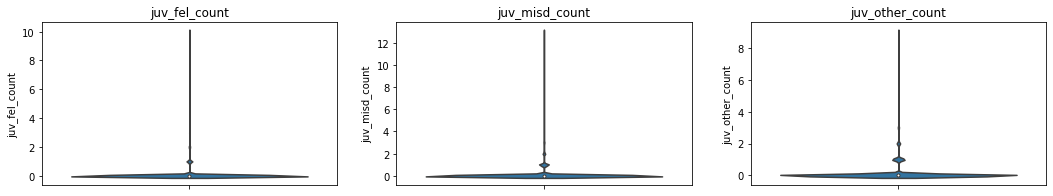

In [40]:
# Check distribution of juvenile case records
fig, ax = plt.subplots(1,3,figsize=(18,3))

#Create plots
for i, feature in enumerate(['juv_fel_count', 'juv_misd_count', 'juv_other_count']):
    sns.violinplot(y=feature, orient="v", data=df_clean, ax=ax[i]);
    ax[i].set_title(feature)

In [41]:
print(f"Defendants with >0 juv_fel_count: {df_clean[df_clean['juv_fel_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_fel_count']>0].shape[0]/df_clean.shape[0],2)}%")
print(f"Defendants with >0 juv_misd_count: {df_clean[df_clean['juv_misd_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_misd_count']>0].shape[0]/df_clean.shape[0],2)}%")
print(f"Defendants with >0 juv_other_count: {df_clean[df_clean['juv_other_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_other_count']>0].shape[0]/df_clean.shape[0],2)}%")

Defendants with >0 juv_fel_count: 164, 0.03%
Defendants with >0 juv_misd_count: 277, 0.05%
Defendants with >0 juv_other_count: 368, 0.07%


- The vast majority of defendants in this dataset has no criminal juvenile records. 
- Even though the numbers are relatively small, there is no indication that there was an error in creating the dataset
- These repeated juvenile offenders seem to be rare, but valid "outliers" and thus should not be removed!

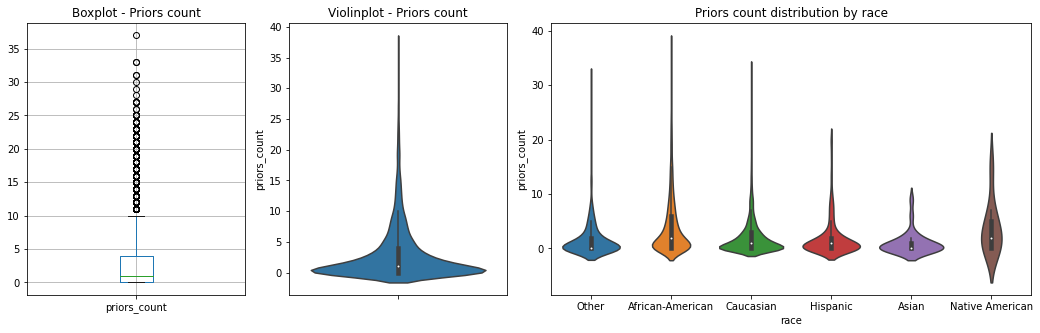

In [42]:
# Check distribution of priors 
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1,4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2:])

df_clean[["priors_count"]].boxplot(ax=ax1) # Create boxplot
ax1.set_title("Boxplot - Priors count")

sns.violinplot(y="priors_count", data=df_clean, orient="v", ax=ax2) # Create violinplot
ax2.set_title("Violinplot - Priors count")

sns.violinplot(x="race", y="priors_count", data=df_clean, orient="v", ax=ax3) # Age distribution by raceAge distribution by race as Violinplots
ax3.set_title("Priors count distribution by race");

In [43]:
print(f"Defendants with >10 priors: {df_clean[df_clean['priors_count']>10].shape[0]}, \
{np.round(df_clean[df_clean['priors_count']>10].shape[0]/df_clean.shape[0],2)}%")

Defendants with >10 priors: 365, 0.07%


There are 365 defendants with more than 10 priors. Nevertheless these repeated offenders seem to be rare, but valid "outliers" and thus should not be removed!

## Scoring metrics

During our modeling journey we will try out multiple models. In order to compare those models and to finally choose the best estimator we need to assess each model performance from different perspectives using different scoring metrics.

### Choose scoring metrics

**Classification**

We have an uneven class distribution in our target

In [44]:
#Checking class distribution of target y
(df_clean.two_year_recid.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

0    63.40%
1    36.60%
Name: two_year_recid, dtype: object

We will try to predict whether a person will re-offend in the following two years or not. 
- The cost of false positives (predict that someone will re-offend, but did not) is high for the defendant, since the person will probably stay in custody until trial. 
- The cost of false negatives (predict that someone will not re-offend, but did) is high for society since most crimes include a victim



In [45]:
clf_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss']

---
**Regression**

In [46]:
# Explanaiton what metrics to choose 

In [47]:
# Placeholder for regression scoring (or part of regression notebook)?

### Create functions for storing results from cross validation and GridSearch

- We will use cross validation and GridSearch to assess models performance and hyperparameter tuning. 
- We will store the cross validated and GridSearch results as well as the model name in different lists which in the end will be used to compare the different estimators and select the best model

In [48]:
# List for cross validated models (no GridSearch)
cv_results_list=[]
cv_models_list=[]

# List for cross validated models using GridSearch
grid_results_list=[]
grid_models_list=[]

# Dictonary of trained models
dict_models = {}

In [49]:
def save_cv_results(cv_results_list, model_name_list):
    '''Store cv results for all splits and metrics as a list of df'''
    cv_results_df=[]
    
    for i, cv_results in enumerate(cv_results_list):
    
        cv_results = pd.DataFrame(cv_results)

        # Subsetting cv_results (exclude time metrics)
        time_metrics = ['fit_time','score_time'] # fit time metrics
        cv_results_nofit = cv_results.loc[:,~cv_results.columns.isin(time_metrics)].copy()

        #Rename negative log loss and change values to positives (for plotting reasons)
        if "test_neg_log_loss" in cv_results_nofit.columns:
            # Change neg_log_loss to positive number (for plotting) and rename columns
            cv_results_nofit["test_neg_log_loss"] = cv_results_nofit["test_neg_log_loss"].abs()
            cv_results_nofit.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
        
        cv_results_nofit["model"]=model_name_list[i]
        cv_results_df.append(cv_results_nofit)
        
    return cv_results_df
    # Create df for plot
    #final_nofit_plot = pd.melt(final_nofit, id_vars=['model'], var_name='metrics', value_name='values')

In [50]:
def save_grid_cv_results(grid_model_list, model_name_grid_list, scorings):
    '''Store cv results for each split for each metric of GridSearch of best model as list of df'''
    grid_cv_results_df=[]
    
    for i, grid_model in enumerate(grid_model_list):

        # get index of best model 
        indx = grid_model.cv_results_["params"].index(grid_model.best_params_)

        # Filter grid search cv results for best model
        cv_results_grid = {k:v[indx] for (k,v) in grid_model.cv_results_.items() if k.startswith('split')}

        #scoring metrics
        col_dict = ["test_"+x for x in scorings]

        # Creat dict for plotting with results for each split for each metric of GridSearch for best model
        final_dict = {}
        for col in col_dict:
            for (k,v) in cv_results_grid.items():
                if k.endswith(col):
                    final_dict.setdefault(col, []).append(v)

        df_final = pd.DataFrame(final_dict)
        df_final["model"]=model_name_grid_list[i]

        #Rename negative log loss and change values to positives (for plotting reasons)
        if "test_neg_log_loss" in col_dict:
            # Change neg_log_loss to positive number (for plotting) and rename columns
            df_final["test_neg_log_loss"] = df_final["test_neg_log_loss"].abs()
            df_final.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
    
        grid_cv_results_df.append(df_final)
        
    
    return grid_cv_results_df

# Feature Engineering

Since the number of features in our dataset is fairly limited we tried to creare a new meaningful feature. 

## Create feature `c_charge_degree_detailed`

The current charges of the ProPublica dataset are categorized as felonies or misdemeanors (`c_charge_degree`):
- A felony represents a serious crime, punishable by death or life imprisonment
- Misdemeanours are crimes that are less serious in comparison to felonies, and thus have less penalties.
    
**Felonies**
- Punishment for a felony can range between one year and death, depending on the felony and degree of the felony.
- The Florida legislature has divided felony crime into **five categories**
    - Third degree felony (F3)
        - Among the different felony charges, the felonies of third degree are the least serious type.
        - E.g. illegal drug possession, burglary, drive under influence ...
    - Second degree felony (F2)
        - The second degree felonies are more serious and carry a heavier sentence compared to the first degree.
        - E.g. aggravated battery with a weapon, child abuse, sexual battery ...
    - First degree felony (F1)
        - The most heinous or inhumane conduct falls into the category of first degree felony.
        - E.g. DUI manslaughter, robbery with a weapon, human trafficking
    - Life felony
        - A few crimes go beyond one’s imagination. A life felony is extremely serious
        - E.g. kidnapping, possessing, selling, or using a weapon of mass destruction, accomplice to murder ...
    - Capital felony
        - Capital felony refers to a heinous crime like murder.
        - E.g. murder, capital drug trafficking, armed kidnapping ...
        
**Misdemeanours**:
Misdemeanors are classified into **first and second degree crimes** in Florida
- First degree (M1):
    - More serious type
    - E.g. (Simple) Battery, Shoplifting, Prostitution, Vandalism ...
- Second degree (M2):
    - More serious type
    - E.g. simple assault, driving with a suspended license, first-offense petit theft ...
  
The `c_charge_desc` contains the description of the crime (e.g. murder, Grand theft ...)

In [51]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df_clean.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df_clean[df_clean["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df_clean[df_clean["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))

Unique charges in the dataset: 359
Unique charges for felonies: 266
Unique charges for misdemeanors: 126


- In order to reduce the variaty of charges we created a new feature to cluster each charge into the correct degree
- The original dataset already contains the more detailed description of the degree of the charge, but unfortunately only for the recidivist crimes (happened after COMPAS scoring)
- We used these crimes to create a lookup table to classify the current charges 

In [52]:
# check unique values/ classes of charges 
df_clean.r_charge_degree.unique()

array([nan, '(F3)', '(M1)', '(F2)', '(M2)', '(MO3)', '(F1)', '(F6)',
       '(F7)', '(CO3)', '(F5)'], dtype=object)

In [53]:
# Create lookup table for c_charge_degree_detailed based on c_charge_desc
lookup_c_charge_degree = pd.merge(
    df_clean[["c_charge_desc"]], 
    df_clean[
        (df_clean["r_charge_degree"]!='(MO3)') & #filter out special classifications of felonies and misdemeanors
        (df_clean["r_charge_degree"]!='(F6)') &
        (df_clean["r_charge_degree"]!='(F7)') &
        (df_clean["r_charge_degree"]!='(CO3)') & 
        (df_clean["r_charge_degree"]!='(F5)') &
        (df_clean["r_charge_degree"]!=np.nan)
        ][["r_charge_degree", "r_charge_desc"]], 
    left_on="c_charge_desc", 
    right_on="r_charge_desc")

In [54]:
#drop duplicated c_charge_desc so we end up with unique charges and degrees
lookup_c_charge_degree = lookup_c_charge_degree[["c_charge_desc", "r_charge_degree"]].drop_duplicates()
lookup_c_charge_degree.columns = ["c_charge_desc", "c_charge_degree_detailed"]

#reset index 
lookup_c_charge_degree = lookup_c_charge_degree.reset_index(drop=True)
lookup_c_charge_degree

,c_charge_desc,c_charge_degree_detailed
0,Felony Battery w/Prior Convict,(F3)
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
...,...,...
169,Deliver Cannabis 1000FTSch,(F2)
170,Sex Batt Faml/Cust Vict 12-17Y,(F1)
171,Possession Of Clonazepam,(F3)
172,Deliver Cocaine 1000FT School,(F1)


In [55]:
#Find charges which do have multiple charge_degrees
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
12,Susp Drivers Lic 1st Offense,(M2)
13,Susp Drivers Lic 1st Offense,(M1)
29,False Ownership Info/Pawn Item,(F3)
30,False Ownership Info/Pawn Item,(F2)
36,Petit Theft,(M2)
37,Petit Theft,(M1)


- Some charges can not always be categorized into one single degree. The degree will most probably also depend on the circumstances of the crime and the criminal record of the defendant.
- However, for our lookup table we will have to choose one of the degrees for each duplicate charge
- We decided to keep the more serious crime in the lookup table. This may of course introduce bias into our dataset

In [56]:
#Decide for one degree for each duplicate -> we keep the harder class degrees (based on online research)
rows_to_drop = [2, 4, 12, 13, 29, 36, 43, 53, 65, 88]

#drop rows based on index 
lookup_c_charge_degree = lookup_c_charge_degree.drop(index=rows_to_drop)

In [57]:
#check that there are no more duplicates 
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed


In [58]:
#set index to c_charge_desc and drop row with c_charge_desc = NaN
lookup_c_charge_degree.set_index("c_charge_desc", inplace=True)
lookup_c_charge_degree = lookup_c_charge_degree[lookup_c_charge_degree.index.notnull()]

#Remove parenthesis from the labels 
lookup_c_charge_degree["c_charge_degree_detailed"] = lookup_c_charge_degree.c_charge_degree_detailed.str.strip("( )")

In [59]:
#Use lookup table to label charges based on description
charges_to_label = df_clean.merge(lookup_c_charge_degree, how="left", left_on="c_charge_desc", right_index=True)

In [60]:
charges_to_label[charges_to_label["c_charge_degree_detailed"].notna()].shape

(4099, 17)

- 4099 of the 5304 cases could be labeled automatically based on the `r_charge_degree` and `r_charge_desc`
- Unfortunately this means also that the remaining cases/charges need to be labeled manually

### Create list for charges which could not be matched automatically and need to be labeled manually

In [61]:
#Filter for rows which could not be labeled by the current lookup table (because they did not exist in r_charge_desc)
charges_to_label = charges_to_label[charges_to_label["c_charge_degree_detailed"].isnull()]

In [62]:
# Create list of unique charges which could not be labeled. These charges need to be labeled manually (online research)
charges_to_label_list = charges_to_label.groupby("c_charge_desc")[["id"]].count().sort_values(by="id", ascending=False)
charges_to_label_list["c_charge_degree_detailed"]=""
charges_to_label_list.columns = ['count', 'c_charge_degree_detailed']

charges_to_label_list

,count,c_charge_degree_detailed
c_charge_desc,,
arrest case no charge,684,
Felony Driving While Lic Suspd,73,
Susp Drivers Lic 1st Offense,45,
Aggravated Assault w/Firearm,20,
Poss Contr Subst W/o Prescript,15,
...,...,...
False Name By Person Arrest,1,
Falsely Impersonating Officer,1,
Grand Theft of a Fire Extinquisher,1,


There are 684 cases where the defendant wasn't pressed with charges (`arrest case no charge`). We decided to encode these charges `0` (less severe than M2 misdemeanors)

In [63]:
# Export to .csv file so the charges can be labeled manually (only has to be executed once)
# charges_to_label_list.to_csv("charges_to_label.csv")

### Import manually labeld .csv file and combine with `lookup_c_charge_degree` to create master lookup table

In [64]:
# import manually labeled data
labeled_charges_man = pd.read_csv("charges_labeled_man.csv", index_col=0).set_index("c_charge_desc")[["c_charge_degree_detailed"]]

In [65]:
#Create master lookup table by combining manually labeled data with automatically labeled data
lookup_c_charge_degree_master = pd.concat([lookup_c_charge_degree, labeled_charges_man], axis=0)

In [66]:
# Save master lookup table as .csv so it can be imported directly (only has to be executed once)
#lookup_c_charge_degree_master.to_csv("labeled_charges_master.csv")

### Map charge degree to all cases and store in new feature column `c_charge_degree_detailed`

In [67]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [68]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df_clean = df_clean.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df_clean.reset_index(drop=True, inplace=True)

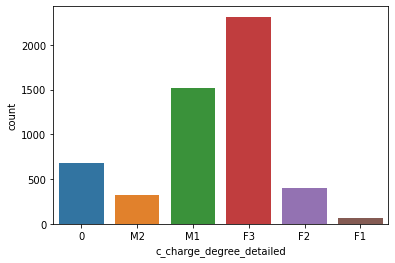

In [69]:
sns.countplot(x="c_charge_degree_detailed", data=df_clean, order=["0","M2", "M1", "F3", "F2", "F1"]);

- The majority of charges in our dataset were labeled as M1 or F3 
- 684 cases are encoded as 0 (arrest case no charge)

In [70]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df_clean[df_clean.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed
114,243,39,25 - 45,Male,Caucasian,1,0,0,1,M,NaN,Low,4,NaN,NaN,0,NaN
2191,4521,27,25 - 45,Female,Caucasian,0,0,0,0,F,NaN,Medium,5,NaN,NaN,0,NaN
4031,8299,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,4,NaN,NaN,0,NaN
4202,8679,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,3,NaN,NaN,0,NaN
5183,10737,69,Greater than 45,Female,Caucasian,0,0,0,5,F,NaN,Low,3,NaN,NaN,0,NaN


In [71]:
index_nan_cases = df_clean[df_clean.c_charge_degree_detailed.isnull()].index

- There are still 5 cases which did not have a description of the current charges. 
- These 5 cases need to be imputed during preprocessing

# Data preprocessing

After we checked the data for missing data and outliers, chose the relevant columns for modeling and created a new feature it is now time to preprocess the data for our modeling

## Select relevant features and perform `train_test_split`

Since we wanted to try out models on data with and without race as feature to assess the difference and importance we will create two separate dataframes, one with race as feature and one without.

### Create Dataframe without `race`

In [72]:
#Select features for Classification model of general recidivism
# Select age or age_cat, exclude/ include race
columns_clas = ["age", "age_cat", "sex", #"race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas = df_clean[columns_clas].copy()

X = df_clas.drop(columns="two_year_recid")
y = df_clas["two_year_recid"]

In [73]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

### Create Dataframe with `race`

In [74]:
columns_clas_race = ["age", "age_cat", "sex", "race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas_race = df_clean[columns_clas_race].copy()

X_race = df_clas_race.drop(columns="two_year_recid")
y_race = df_clas_race["two_year_recid"]

In [75]:
# Train test split
X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(X_race,y_race, test_size=0.3)

## Create preprocessing pipeline

For our classification task we decided to use pipelines to streamline the data preprocessing and training of different models. A pipeline is a chain of operations of a Machine Learning project (preprocessing, training, predicting, etc...). It makes the workflow much easier to read and understand and also enforces the implementation and order of steps in the project.
<br>
Our preprocessing pipeline will consist of three pipelines:

- `preproc_numerical` to preprocess numerical features (e.g. age, priors_count ...)
- `preproc_ordinal` to preprocess ordinal features (e.g. c_charge_degree, c_charge_degree_detailed)
- `preproc_nominal` to preprocess categorical features (e.g. sex, race)

We will create two distinct preprocessing pipelines. One for the dataset with and one for the Dataframe without race as a feature. Besides we will also have to create two versions of these two pipelines: One with feature scaling for distanced based algorithms like regularized logistic regression and one without feature scaling for the other algorithms used.<br>
Since we will only plan to use one distance based algorithm (regularized Logistic Regression) we will create the preprocessing pipeline with scaling during the model iteration phase.

### Preprocessing pipeline without `race`as feature

We start with the preprocessing of ordinal features

In [76]:
# Create dict for ordinal features
feat_ordinal_dict = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"]
    }

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

# Instantiate encoder
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

#Create pipeline
preproc_ordinal = make_pipeline(
    encoder_ordinal,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values for c_charge_degree_detailed 
#    StandardScaler()
#    MinMaxScaler()
)


Next we create the pipeline for numerical features. 

In [77]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
#    MinMaxScaler()
)

The features which are neither being processed in the ordinal nor in the numerical pipeline will be one-hot-encoded in the nominal pipeline.

In [78]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X_train.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

Putting the three pipelines into one column transformer will enable us to preprocess the different features in parallel.  

In [79]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal), 
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2',
                                                                              'M1',
                                                                              'F3',
                                                                              'F2',
                                                                              'F1']],
                                                                 dtype=<cl...>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25))]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['sex'])])

Let's check if the pipeline is preprocessing our data correctly: 

In [80]:
#Test preproc pipeline
preproc.fit(X_train)
column_nam = feat_numerical + feat_ordinal +list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))
X_train_trans = pd.DataFrame(preproc.transform(X_train), columns=column_nam)
X_train_trans.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,sex_Male
0,35.0,0.0,0.0,0.0,12.0,1.0,1.0,3.0,0.0
1,30.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0
2,34.0,0.0,0.0,0.0,5.0,1.0,1.0,3.0,1.0


### Preprocessing pipeline with `race`as feature

The race feature will be one-hot-encoded in the nominal pipeline.

In [81]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal_r = sorted(list(set(X_race.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal_r = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="first")
)

In [82]:
preproc_race = make_column_transformer(
    (preproc_numerical, feat_numerical), #stays the same since race is a nominal feature
    (preproc_ordinal, feat_ordinal), #stays the same since race is a nominal feature
    (preproc_nominal_r, feat_nominal_r), 
    remainder="drop")

preproc_race

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2',
                                                                              'M1',
                                                                              'F3',
                                                                              'F2',
                                                                              'F1']],
                                                                 dtype=<cl...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25))]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['race', 'sex'])])

In [83]:
#Test preproc race pipeline
preproc_race.fit(X_race)

column_nam_r = feat_numerical + feat_ordinal+list(preproc_race.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_r))

test = pd.DataFrame(preproc_race.transform(X_race), columns=column_nam_r)
test.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,69.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0
1,34.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
2,24.0,0.0,0.0,1.0,4.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0


## Balancing

- As we already saw in the data exploration, the number of data points of the COMPAS dataset representing `two_years_recid` (and `race` and `sex`) are not evenly distributed (imbalanced)
- This may pose a problem since machine learning algorithms learn by example and could therefore tend to predict under-represented classes poorly
- We therefore chose to balance our **training data** to include the same number of recidivists and non-recidivists. 

In [84]:
# Check class distribution of target two_years_recid
(df.two_year_recid.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

0    63.40%
1    36.60%
Name: two_year_recid, dtype: object

In [85]:
print("Number of unique cases in dataset:",df_clean.shape[0])

Number of unique cases in dataset: 5304


- To balance a dataset we can either undersample the majority class (by disregarding rows) or oversample by creating copies of the minority class.
- Since our original dataset is already relatively small, we decided against sampling down the majority class 
- We will therefore oversample the minority class, but not by copying instances, but by using the SMOTE algorithm. 

![Difference overampling and undersampling](img/over_undersample.png)
[Source](https://miro.medium.com/max/700/1*P93SeDGPGw0MhwvCcvVcXA.png)


### SMOTE

- Synthetic Minority Oversampling Technique (SMOTE) is an oversampling algorithm that generates new minority instances from existing minority instances based on linear combinations of existing points (see illustrative figure below)
- We only use balancing techniques on the training set. We want to keep our test set as representative of real life as possible.


![Example_SMOTE](img/SMOTE.png)
[Source](https://imbalanced-learn.org/stable/_images/sphx_glr_plot_comparison_over_sampling_006.png)


#### Instantiate SMOTE for balancing into pipeline without `race`

Since the imblearn make_pipeline function is not 100% compatible with the sklearn make_pipeline function we can only chain the balancing step and the final predictor to our preproc pipeline in one step. Therefore we will create the final pipelines during model iteration

In [86]:
#Order of columns after preprocessing pipeline
column_nam

['age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'age_cat',
 'c_charge_degree',
 'c_charge_degree_detailed',
 'sex_Male']

In [87]:
sm = SMOTENC(categorical_features=range(5,9)) # index of categorical features (for order see column_nam)
smt = SMOTETomek(smote=sm)

#### Instantiate SMOTE for balancing into pipeline with `race`

In [88]:
#Order of columns after preprocessing pipeline
column_nam_r

['age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'age_cat',
 'c_charge_degree',
 'c_charge_degree_detailed',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Native American',
 'race_Other',
 'sex_Male']

In [89]:
sm_race = SMOTENC(categorical_features=range(5,15)) # index of categorical features (for order see column_nam_r)
smt_race = SMOTETomek(smote=sm_race)

# Feature selection

- Some of the columns are different representations of the same data (eg. `age` and `age_cat`) and are therfore highly correlated
- Furthermore we want to remove features that, when in combination with all the others, do not really help predict our target
- In this chapter we will assess different feature importance criteria

## Feature correlation

Use Pearson's correlation combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others.
> High correlation = redundant information

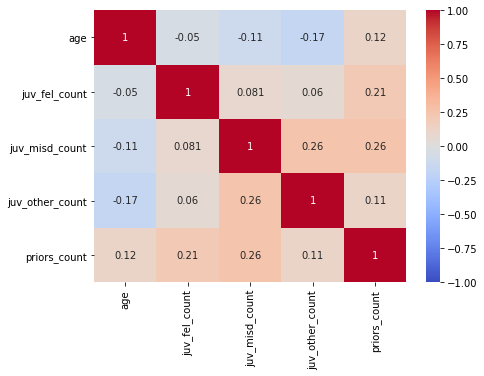

In [90]:
corr_num = X_train.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1, annot=True);

In [91]:
corr_df = corr_num.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
13,juv_misd_count,juv_other_count,0.257501
17,juv_other_count,juv_misd_count,0.257501
22,priors_count,juv_misd_count,0.257007
14,juv_misd_count,priors_count,0.257007
9,juv_fel_count,priors_count,0.212775


There seems to be a slight correlation between `juv_misd_count` and `juv_other_count` and between `juv_misd_count` and `priors_count`. However, the correlation does not seem hig enough to drop any of those features. 

---

For **ordinal features**, we can use Spearman's rank correlation instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others.

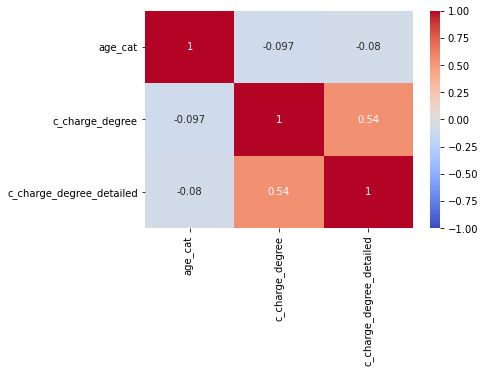

In [92]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]), columns=feat_ordinal)
sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1, annot=True);

- Using Spearman we see a high correlation between `c_charge_degree` and `c_charge_degree_detailed`
- This makes sense, since the `c_charge_degree_detailed` is our engineered feature which is a more granular classification of felonies and misdemeanors. We should therefore drop one of the features
- However, using Spearman only for the ordinally encoded features we can not assess the correlation between `age` and `age_cat` and any possible correlation between `sex` and the other features. This correlation assessment could only been performed after encoding.

---
- In order to assess the correlation between all features we use the transformed and encoded features. 
- We see the high correlation between `age_cat` and `age` and `c_charge_degree` and `c_charge_degree_detailed`

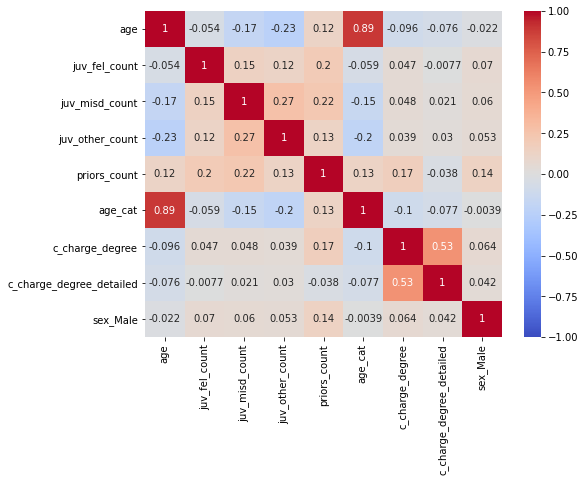

In [93]:
df_enc = pd.DataFrame(preproc.fit_transform(X_train), columns=column_nam)
fig = plt.figure(figsize=(8,6))
sns.heatmap(df_enc.corr(method="spearman"), cmap='coolwarm',vmin=-1, vmax=1, annot=True);

### Assess correlation on complete dataset (including `race` and `y`)

We also decided to assess the correlation between all features (including race) and the target 

In [94]:
# Define numerical feature once-for-all for race pipeline
feat_numerical_y = sorted(df_clas.select_dtypes(include=["int64", "float64"]).columns)

In [95]:
#Create preproc pipeline with race and target y
preproc_ra_y = make_column_transformer(
    (preproc_numerical, feat_numerical_y), #stays the same since race is a nominal feature
    (preproc_ordinal, feat_ordinal), #stays the same since race is a nominal feature
    (preproc_nominal_r, feat_nominal_r), 
    remainder="drop")

preproc_ra_y;

In [96]:
#Test preproc_ra_y pipeline
preproc_ra_y.fit(df_clean)

column_nam_ra_y = feat_numerical_y + feat_ordinal+ list(preproc_ra_y.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_r))

df_enc_race = pd.DataFrame(preproc_ra_y.transform(df_clean), columns=column_nam_ra_y)

df_enc_race.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,age_cat,c_charge_degree,c_charge_degree_detailed,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,69.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0
1,34.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
2,24.0,0.0,0.0,1.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0


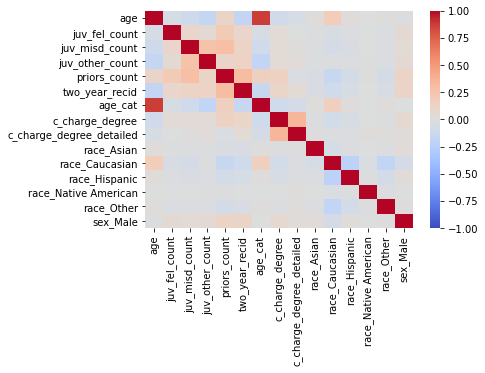

In [97]:
sns.heatmap(df_enc_race.corr(), cmap='coolwarm',vmin=-1, vmax=1);

Looking at our target, there seems to be a positive correlation with the number of priors of the defendant and a negative correlation with age. Also we can see there is a slight positive correlation with african american and a slight negative correlation with caucasian. We will keep this in mind for our fairness discussion. 

## Feature permutation (MDA)

We want to remove features that, when in combination with all the others, do not really help predict our target.

To do so, we use `permutation_importance` in combination with an estimator! It trains one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

In [98]:
# Create pipeline with vanilla Random Forest Classifier
pipe_forest = imblearn_make_pipeline(preproc, smt, RandomForestClassifier())
pipe_forest.fit(X_train, y_train)

# Calculate permutation score
permutation_score = permutation_importance(pipe_forest, X_train, y_train, n_repeats=10) # Perform Permutation
sorted_idx = permutation_score.importances_mean.argsort()

In [99]:
# Create df of permutation scores (for plotting reasons)
per_df =pd.DataFrame(permutation_score.importances[sorted_idx].T, columns=np.array(X_train.columns)[sorted_idx])
per_df["model"]= "model"
per_scr = pd.melt(per_df, id_vars="model", var_name="features", value_name="permutation_score")

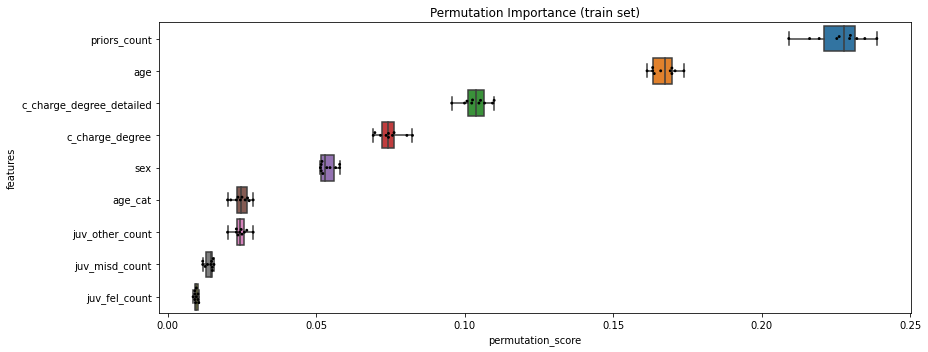

In [100]:
#Plot MDA train set
fig = plt.figure(figsize=(13, 5))

sorted_idx = permutation_score.importances_mean.argsort()
sns.boxplot(
    data=per_scr,
    y="features",
    x="permutation_score",
    order=np.flip(np.array(X_train.columns)[sorted_idx]),
    whis=np.inf
)
sns.swarmplot(
    data=per_scr,
    y="features",
    x="permutation_score",
    order=np.flip(np.array(X_train.columns)[sorted_idx]),
    size=2.9,
    color="black");

plt.title("Permutation Importance (train set)")
fig.tight_layout()

- Using feature permutation, we see that the shuffling of the feature `priors count` and `age` leads to the highest decrease in score
- The shuffling of the juvenile charges features lead to the lowest decrease in score. This may be due to the fact, that for the vast majority of defendants there are no (0) juvenile priors
- Based on this plot we could decide to only keep the first four features. However, the shown MDA scores could be biased because `c_charge_degree_detailed` and `c_charge_degree` and `age`and `age_cat` are highly correlated. By shuffling only one of these columns the model could still potenitally have access to the information through the correlated feature. 

### Compare MDA on different subsets of df

In this chapter we will compare the MDA on different subsets of the data:<br>

1) Dataframe **without** `c_charge_degree` and `age_cat`<br>
2) Dataframe **without** `c_charge_degree_detailed` and `age`<br>
3) Better of the first two, but with `race`<br>

For the subsets we have to slightly modify our existing encoding pipelines

#### Dataframe without `c_charge_degree` and `age_cat`

In [101]:
# Create new pipeline without features age_cat and c_charge_degree
feat_ordinal_dict_s = {
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
    }

feat_ordinal_s = sorted(feat_ordinal_dict_s.keys()) # sort alphabetically
feat_ordinal_values_sorted_s = [feat_ordinal_dict_s[i] for i in feat_ordinal_s]

#Ordinal Encoder
encoder_ordinal_s = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

#Create ordinal encoding pipleine
preproc_ordinal_s = make_pipeline(
    encoder_ordinal_s,
    KNNImputer(missing_values=-1, n_neighbors=25), 
    #MinMaxScaler()
)

In [102]:
# Create preprocessing pipeline for subset
preproc_s = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal_s, feat_ordinal_s),
    (preproc_nominal, feat_nominal),
    remainder="drop")

In [103]:
# Create pipeline with vanilla Random Forest Classifier
pipe_forest_s = make_pipeline(preproc_s, RandomForestClassifier())
pipe_forest_s.fit(X_train, y_train);

In [104]:
# Transform X_train to test if pipeline works correctly
column_nam_sub = feat_numerical + feat_ordinal_s +list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))
X_train_sub_trans = pd.DataFrame(preproc_s.transform(X_train), columns=column_nam_sub)

X_train_sub_trans.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male
0,35.0,0.0,0.0,0.0,12.0,3.0,0.0
1,30.0,0.0,0.0,0.0,1.0,2.0,1.0
2,34.0,0.0,0.0,0.0,5.0,3.0,1.0


The pipeline seems to work correctly. We will now calculate the permutation score for this subset.

In [105]:
# Calculate permutation score
permutation_score_s1 = permutation_importance(pipe_forest_s, X_train[feat_numerical + feat_ordinal_s+feat_nominal], y_train, n_repeats=10) # Perform Permutation

#### Dataframe without `c_charge_degree_detailed` and `age`

In [106]:
# Create new pipeline without features c_charge_degree_detailed and age
feat_ordinal_dict_s2 = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    "c_charge_degree": ["M", "F"],
    }

feat_ordinal_s2 = sorted(feat_ordinal_dict_s2.keys()) # sort alphabetically
feat_ordinal_values_sorted_s2 = [feat_ordinal_dict_s2[i] for i in feat_ordinal_s2]

#Ordinal Encoder
encoder_ordinal_s2 = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s2,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

#Create ordinal encoding pipeline
preproc_ordinal_s2 = make_pipeline(
    encoder_ordinal_s2,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
    #MinMaxScaler()
)

In [107]:
# Define numerical feature 
feat_numerical_s2 = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
feat_numerical_s2.remove("age") #Remove age from list of numerical features

# Create pipeline for numerical features
preproc_numerical_s2 = make_pipeline(
    SimpleImputer(),
    #MinMaxScaler()
)

In [108]:
# Create preprocessing pipeline for second subset
preproc_s2 = make_column_transformer(
    (preproc_numerical_s2, feat_numerical_s2),
    (preproc_ordinal_s2, feat_ordinal_s2),
    (preproc_nominal, feat_nominal),
    remainder="drop")

pipe_forest_s2 = make_pipeline(preproc_s2, RandomForestClassifier())
pipe_forest_s2.fit(X_train, y_train);

In [109]:
permutation_score_s2 = permutation_importance(pipe_forest_s2, X_train[feat_numerical_s2 + feat_ordinal_s2 +feat_nominal], y_train, n_repeats=10) # Perform Permutation

#### Comparison of permutation scores for both subsets

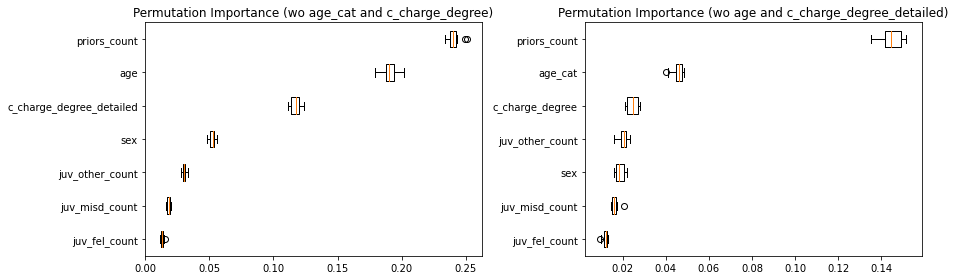

In [110]:
# Both plots side by side
fig = plt.figure(figsize=(13,4))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s+feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

plt.subplot(1, 2, 2)
sorted_idx = permutation_score_s2.importances_mean.argsort()
plt.boxplot(
    permutation_score_s2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical_s2 + feat_ordinal_s2 +feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed)")

fig.tight_layout()
plt.show();

- We see more important features in the subset with `age` and `c_charge_degree_detailed`
- Removing `age_cat` and `c_charge_degree` also led to an increase of the overall importance for the other features
- We will now check if including `race` as a feature to the subset might lead to a further increase in permutation scores

#### Dataframe without `c_charge_degree` and `age_cat`, but with `race`

In [111]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal_rs = sorted(list(set(X_race.columns.drop(["age_cat", "c_charge_degree"])) - set(feat_numerical) - set(feat_ordinal_s)))

# Nominal pipeline
preproc_nominal_rs = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [112]:
# Create pipeline 
preproc_rs = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal_s, feat_ordinal_s),
    (preproc_nominal_rs, feat_nominal_rs),
    remainder="drop")

# Train model
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, RandomForestClassifier())
pipe_forest_rs.fit(X_train_race, y_train_race);

In [113]:
# Transform X_train_race to test if pipeline works correctly
column_nam_rsub = feat_numerical + feat_ordinal_s +list(preproc_rs.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_rs))
X_train_rsub_trans = pd.DataFrame(preproc_rs.transform(X_train_race), columns=column_nam_rsub)
X_train_rsub_trans.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,35.0,0.0,0.0,0.0,12.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,34.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Everythings seems to work fine. Let's continue with the calculation of the permutation scores and compare them with the first subset (wo. `age_cat` and `c_charge_degree`)

In [114]:
permutation_score_rs = permutation_importance(pipe_forest_rs, X_train_race[feat_numerical + feat_ordinal_s+feat_nominal_rs], y_train_race, n_repeats=10) # Perform Permutation

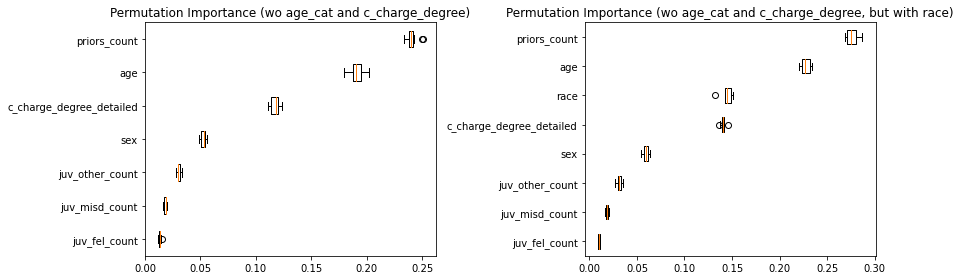

In [115]:
# Both plots side by side
fig = plt.figure(figsize=(12.5,4))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s+feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

plt.subplot(1, 2, 2)
sorted_idx = permutation_score_rs.importances_mean.argsort()
plt.boxplot(
    permutation_score_rs.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s +feat_nominal_rs)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree, but with race)")

fig.tight_layout()
plt.show();

Including `race` as a feature seems to further increase the overall importance of the different features. We will  will therefore also use this pipeline in the further modeling journey.

## Impurity reduction (MDI)

We also use the bulit-in feature importance measure from tree based models to assess the feature importance

In [116]:
# Instantiate Random Forest Classifier for MDI 
clf_forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, clf_forest)
pipe_forest.fit(X_train, y_train);

In [117]:
# Create new balancer for subset pipeline
sm_s = SMOTENC(categorical_features=[5,6]) # index of categorical features (for order see column_nam_sub)
smt_s = SMOTETomek(smote=sm_s)

# Instantiate Random Forest Classifier on Subset for MDI 
clf_forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, clf_forest)
pipe_forest_s.fit(X_train, y_train);

In [118]:
# # We have to reinstatiate the preproc_rs pipeline to change the OHE to drop="first"
# # Nominal pipeline
# preproc_nominal_rs = make_pipeline(
#     SimpleImputer(strategy="most_frequent"),
#     OneHotEncoder(handle_unknown="ignore", drop="first")
# )

# # Create pipeline 
# preproc_rs = make_column_transformer(
#     (preproc_numerical, feat_numerical),
#     (preproc_ordinal_s, feat_ordinal_s),
#     (preproc_nominal_rs, feat_nominal_rs),
#     remainder="drop")

# preproc_rs.fit(X_train_race, y_train_race)

# # Transform X_train_race to test if pipeline works correctly
# column_nam_rsub = feat_numerical + feat_ordinal_s +list(preproc_rs.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_rs))
# X_train_rsub_trans = pd.DataFrame(preproc_rs.transform(X_train_race), columns=column_nam_rsub)
# X_train_rsub_trans.head(3)

In [119]:
# Create new balancer for subset pipeline with race
sm_rs = SMOTENC(categorical_features=np.arange(5,13)) # index of categorical features (for order see column_nam_rsub)
smt_rs = SMOTETomek(smote=sm_rs)

# Instantiate Random Forest Classifier on Subset for MDI 
clf_forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_rs, clf_forest)
pipe_forest_rs.fit(X_train_race, y_train_race);

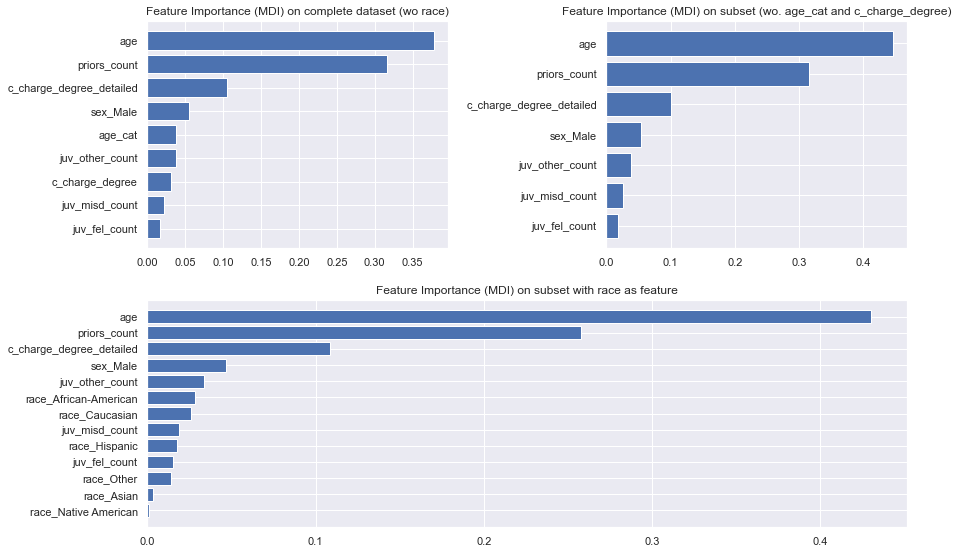

In [120]:
sns.set_theme()
# Create subplots
fig = plt.figure(figsize=(13,8))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

#Plot MDA on complete dataset
feature_importance = pipe_forest.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
ax1.barh(pos, feature_importance[sorted_idx], align="center")
ax1.set_yticks(pos)
ax1.set_yticklabels(np.array(X_train_trans.columns)[sorted_idx])
ax1.set_title("Feature Importance (MDI) on complete dataset (wo race)");

#Plot MDA on subset
feature_importance_s = pipe_forest_s.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_s)
pos = np.arange(sorted_idx.shape[0]) + 0.5
ax2.barh(pos, feature_importance_s[sorted_idx], align="center")
ax2.set_yticks(pos)
ax2.set_yticklabels(np.array(X_train_sub_trans.columns)[sorted_idx])
ax2.set_title("Feature Importance (MDI) on subset (wo. age_cat and c_charge_degree)");

#Plot MDA on subset with race
feature_importance_rs = pipe_forest_rs.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_rs)
pos = np.arange(sorted_idx.shape[0]) + 0.5
ax3.barh(pos, feature_importance_rs[sorted_idx], align="center")
ax3.set_yticks(pos)
ax3.set_yticklabels(np.array(X_train_rsub_trans.columns)[sorted_idx])
ax3.set_title("Feature Importance (MDI) on subset with race as feature");


plt.tight_layout(pad=1.5)

- For all subsets the 4 most important features are `age`, `priors_count`, `c_charge_degree_deatiled` and `sex_Male`. These features were also selected by the MDA. 
- However, after OHE the model with race it seems that `race_African_American` and `race_Caucasian` also seem to have an influence on the impurity reduction

## Forward- and backward-feature selection using `SequentialFeatureSelector` 

One last feature selection technique we had a look at was forward- and backward feature selction:
- This is an iterative method in which we keep greedly adding (or removing in case of backward selection) the feature which best (least) improves our model until a stopping criteria is met.
- Forward selection starts with an empty set of variables and adds variables to it, until a stopping criterion is met. - Similarly, backward selection starts with a complete set of variables and then excludes variables from that set, again, until some stopping criterion is met.

### Forward feature selection

We tried in three different models for the forward- and backward feature selection technique. In this chapter we only used the subset without race.

In [121]:
# Select models to try out
sfs_models = [LogisticRegression(solver='liblinear', penalty='l1'), LogisticRegression(), DecisionTreeClassifier()]
sfs_results = []

In [122]:
# Create new pipeline without features age_cat and c_charge_degree with scaling

#Create ordinal encoding pipleine
preproc_ordinal_s_scaled = make_pipeline(
    encoder_ordinal_s,
    KNNImputer(missing_values=-1, n_neighbors=25), 
   StandardScaler()
)

preproc_numerical_scaled = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

# Create preprocessing pipeline for subset
preproc_s_scaled = make_column_transformer(
    (preproc_numerical_scaled, feat_numerical),
    (preproc_ordinal_s_scaled, feat_ordinal_s),
    (preproc_nominal, feat_nominal),
    remainder="drop")

We used `GridSearchCV` to assess the change of scores based on the number of features selected for each model.
Since the GridSearch takes a fairly long time, we exported the trained model using `joblib`, commented out the training part and import the trained model. This way the notebook can be run more quickly and it is more convienient to recreate our findings. We used this technique also in our model iteration. 

In [123]:
# for model in sfs_models:
#     sfs_forward = SequentialFeatureSelector(model, direction="forward", cv=5)
#     pipe_sfs = imblearn_make_pipeline(preproc_s_scaled, smt_s, sfs_forward, model)
    
#     param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,7)}

#     grid_sfs = GridSearchCV(pipe_sfs, param_grid, 
#                               cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#     grid_sfs.fit(X_train, y_train);
#     print(str(model))
#     print(grid_sfs.best_params_)
#     print(grid_sfs.best_score_)
    
#     sfs_results.append(grid_sfs)

In [124]:
# joblib.dump(sfs_results[0], 'stored_models/grid_sfs_log_l1.pkl')
# joblib.dump(sfs_results[1], 'stored_models/grid_sfs_log.pkl')
# joblib.dump(sfs_results[2], 'stored_models/grid_sfs_tree.pkl')

In [125]:
# Load trained models
sfs_results.append(joblib.load('stored_models/grid_sfs_log_l1.pkl'))
sfs_results.append(joblib.load('stored_models/grid_sfs_log.pkl'))
sfs_results.append(joblib.load('stored_models/grid_sfs_tree.pkl'))

In [126]:
# Create df (for plotting reasons)
sfs_df = []
for i in sfs_results:
    sfs_df.append(i.cv_results_["mean_test_roc_auc"])
sfs_df = pd.DataFrame(sfs_df).T
sfs_df.index = np.arange(2,7)
sfs_df = sfs_df.reset_index()
sfs_df.columns = ["no_features", "LogisticRegression_L1", "LogisticRegression_L2", "DecisionTreeClassifier"]
sfs_df = pd.melt(sfs_df, id_vars="no_features", var_name="models", value_name="mean_test_roc_auc")

sfs_df_log = sfs_df[(sfs_df["models"].str.contains('Logist'))] # Logistic Regression models
sfs_df_tree = sfs_df[~(sfs_df["models"].str.contains('Logist'))] # Tree model

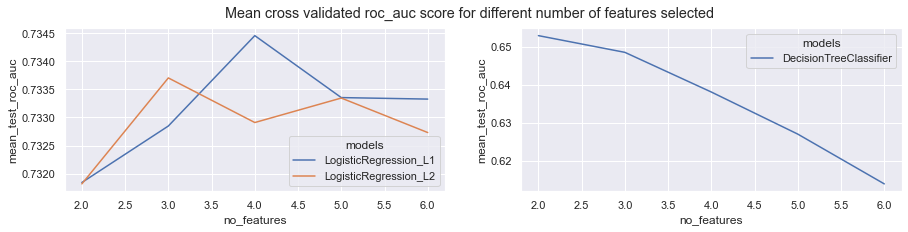

In [127]:
fig, ax = plt.subplots(1,2,figsize=(15,3))
fig.suptitle("Mean cross validated roc_auc score for different number of features selected")
sns.lineplot(data=sfs_df_log, x="no_features", y="mean_test_roc_auc", hue="models", ax=ax[0])
sns.lineplot(data=sfs_df_tree, x="no_features", y="mean_test_roc_auc", hue="models", ax=ax[1]);

- The logisitc regression with l1 penalization was the best performing model
- Surprisingly the overall auc score is higher for the Logisitc regression models than the DecisionTree
- Out of the 7 total features the Logisitic Regression models with l1 penalty reached the maximum score with 4 features, the l2 model with 3 and the DecisionTree maximized the score with 2 features only!
- Below we see the selected features for each model 

In [128]:
# Print selected features for the best model
for i, model in enumerate(sfs_results):
    
    sfs_sel_feat = model.best_estimator_.named_steps["sequentialfeatureselector"].get_support() # Get selected features

    print(sfs_models[i])
    print(f"Selected columns: {X_train_sub_trans.columns[sfs_sel_feat]}")
    print()

LogisticRegression(penalty='l1', solver='liblinear')
Selected columns: Index(['age', 'juv_misd_count', 'priors_count', 'c_charge_degree_detailed'], dtype='object')

LogisticRegression()
Selected columns: Index(['age', 'priors_count', 'c_charge_degree_detailed'], dtype='object')

DecisionTreeClassifier()
Selected columns: Index(['age', 'priors_count'], dtype='object')



- In comparison to the L2 and the L1 Logistic regression model additionally chose `juv_misd_count` 
- The decision tree chose the `age` and `priors_count` features

### Backward feature selection

We use the same models for backward feature selection

In [129]:
# Select models to try out
sfs_models = [LogisticRegression(solver='liblinear', penalty='l1'), LogisticRegression(), DecisionTreeClassifier()]
sfs_results = []

In [130]:
# for model in sfs_models:
#     sfs_backward= SequentialFeatureSelector(model, direction="backward", cv=5)
#     pipe_sfs = imblearn_make_pipeline(preproc_s_scaled, smt_s, sfs_backward, model)
    
#     param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,7)}

#     grid_sfs = GridSearchCV(pipe_sfs, param_grid, 
#                               cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

#     grid_sfs.fit(X_train, y_train);
#     print(str(model))
#     print(grid_sfs.best_params_)
#     print(grid_sfs.best_score_)
    
#     sfs_results.append(grid_sfs)

In [131]:
# joblib.dump(sfs_results[0], 'stored_models/grid_sfs_b_log_l1.pkl')
# joblib.dump(sfs_results[1], 'stored_models/grid_sfs_b_log.pkl')
# joblib.dump(sfs_results[2], 'stored_models/grid_sfs_b_tree.pkl')

In [132]:
# Load trained models
sfs_results.append(joblib.load('stored_models/grid_sfs_b_log_l1.pkl'))
sfs_results.append(joblib.load('stored_models/grid_sfs_b_log.pkl'))
sfs_results.append(joblib.load('stored_models/grid_sfs_b_tree.pkl'))

In [133]:
# Create df (for plotting reasons)
sfs_df = []
for i in sfs_results:
    sfs_df.append(i.cv_results_["mean_test_roc_auc"])
sfs_df = pd.DataFrame(sfs_df).T
sfs_df.index = np.arange(2,7)
sfs_df = sfs_df.reset_index()
sfs_df.columns = ["no_features", "LogisticRegression_L1", "LogisticRegression_L2", "DecisionTreeClassifier"]
sfs_df = pd.melt(sfs_df, id_vars="no_features", var_name="models", value_name="mean_test_roc_auc")

sfs_df_log = sfs_df[(sfs_df["models"].str.contains('Logist'))] # Logistic Regression models
sfs_df_tree = sfs_df[~(sfs_df["models"].str.contains('Logist'))] # Tree model

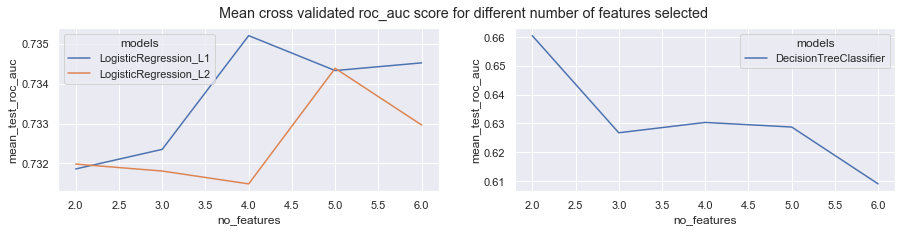

In [134]:
fig, ax = plt.subplots(1,2,figsize=(15,3))
fig.suptitle("Mean cross validated roc_auc score for different number of features selected")
sns.lineplot(data=sfs_df_log, x="no_features", y="mean_test_roc_auc", hue="models", ax=ax[0])
sns.lineplot(data=sfs_df_tree, x="no_features", y="mean_test_roc_auc", hue="models", ax=ax[1]);

By greedely removing features we see a slight different result 
- The logisitic regression with l1 penalization is almost always the best performing model  
- The overall auc score is still higher for the Logisitc regression models than for the DecisionTree
- Out of the 7 total features the Logisitic Regression models with l1 penalty reached the maximum score with 4 features, the l2 Logisitc regression model chose 5 features and the DecisionTree maximized the score again with only 2 features!
- Below we see the selected features for each model 

In [135]:
# Print selected features for the best model
for i, model in enumerate(sfs_results):
    
    sfs_sel_feat = model.best_estimator_.named_steps["sequentialfeatureselector"].get_support() # Get selected features

    print(sfs_models[i])
    print(f"Selected columns: {X_train_sub_trans.columns[sfs_sel_feat]}")
    print()

LogisticRegression(penalty='l1', solver='liblinear')
Selected columns: Index(['age', 'juv_fel_count', 'priors_count', 'c_charge_degree_detailed'], dtype='object')

LogisticRegression()
Selected columns: Index(['age', 'juv_fel_count', 'juv_misd_count', 'priors_count',
       'c_charge_degree_detailed'],
      dtype='object')

DecisionTreeClassifier()
Selected columns: Index(['age', 'priors_count'], dtype='object')



- In comparison to the L2 model the L1 Logistic regression model additionally chose `priors_count` 
- The decision tree again chose the `age` and `priors_count` features

## Summary of feature selection and implications for modeling phase

Based on our assessment of the different feature selection techniques we decided to move further with three different subsets of data: 
1) Complete dataframe (without race) <br>
2) Subset without age_cat and c_charge_degree and race<br>
3) No. 2 but with race  <br>

Since our number of features is already quite small we chose not to further decrease it beforehand. But since most of the models we will try also have some built-in feature selection technique (e.g. L1 regression or trees) it may happen that the final model will not use all of the features.  

# Model iteration

- In our part of Model iteration, we will test our models with the complete datatset of the chosen features, also with the subset where we took out `c_charge_degree` and `age_cat`, and that same subset with `race` included.
- while splitting train and test data, cross-validation is preferred since it gives our model the opportunity to train on multiple train-test splits. 
- Furthermore, we save our model in a list for the later purpose of comparison

## Baseline model

- As a baseline model for the prediction of general recidivism we choose a "Dummy" Classifier which will predict the most frequent class in the target (no_recid).
- The reason was that we detected imbalance class in our dataset.

In [136]:
model_name = "Dummy baseline"
dummy_clf = DummyClassifier(strategy="most_frequent") #Instantiate Dummy Classifier 
baseline = imblearn_make_pipeline(preproc, smt, dummy_clf) #Create pipeline

In [137]:
cv_baseline = cross_validate(baseline, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [138]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_baseline)

In [139]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_baseline['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_baseline['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Dummy baseline: 0.63
10 fold cv ROC AUC score of Dummy baseline: 0.5


- With the dummy classifier, which always predicts the most frequent class in the target (no_recid), we obtain an accuracy score of 63% and ROC  AUC score of 0.5
- It also means that this classifier, without learning anything from the dataset, is capable of predicting that accurate number for accuracy score and ROC AUC score
- `DummyClassifier` has no predict function and thus the precision, recall and f1 metric is set to 0 

## Logistic Regression

### Untuned Logistic Regression

#### Complete Dataset

In [140]:
#Create pipeline with feature scaling
preproc_ordinal_scaled = make_pipeline(
    encoder_ordinal,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values for c_charge_degree_detailed 
    StandardScaler()
#    MinMaxScaler()
)

preproc_numerical_scaled = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
#    MinMaxScaler()
)

preproc_scaled = make_column_transformer(
    (preproc_numerical_scaled, feat_numerical),
    (preproc_ordinal_scaled, feat_ordinal),
    (preproc_nominal, feat_nominal), 
    remainder="drop")

In [141]:
model_name = "Vanilla Logistic Regression"
logreg = LogisticRegression()
pipe_log = imblearn_make_pipeline(preproc_scaled, smt, logreg) ##Create pipeline

In [142]:
cv_logreg = cross_validate(pipe_log, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [143]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg)

In [144]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla Logistic Regression: 0.68
10 fold cv ROC AUC score of Vanilla Logistic Regression: 0.74


In [145]:
pipe_log.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_log

#### Subset

In [146]:
model_name = "Vanilla Logistic Regression_Sub"
logreg = LogisticRegression()
pipe_log_s = imblearn_make_pipeline(preproc_s_scaled, smt_s, logreg) ##Create pipeline

In [147]:
cv_logreg_s = cross_validate(pipe_log_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [148]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg_s)

In [149]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg_s['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla Logistic Regression_Sub: 0.69
10 fold cv ROC AUC score of Vanilla Logistic Regression_Sub: 0.74


In [150]:
pipe_log_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_log_s

#### Subset with race 

In [151]:
# Create new pipeline without features age_cat and c_charge_degree, but with race and with scaling
preproc_rs_scaled = make_column_transformer(
    (preproc_numerical_scaled, feat_numerical),
    (preproc_ordinal_s_scaled, feat_ordinal_s),
    (preproc_nominal_rs, feat_nominal_rs),
    remainder="drop")

In [152]:
model_name = "Vanilla Logistic Regression_rSub"
logreg = LogisticRegression()
pipe_log_rs = imblearn_make_pipeline(preproc_rs_scaled, smt_rs, logreg) ##Create pipeline

In [153]:
cv_logreg_rs = cross_validate(pipe_log_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

In [154]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg_rs)

In [155]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg_rs['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla Logistic Regression_rSub: 0.69
10 fold cv ROC AUC score of Vanilla Logistic Regression_rSub: 0.73


In [156]:
pipe_log_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_log_rs

### Tuned Logistic Regression

#### Complete Dataset

In [157]:
model_name = "Tuned Logistic Regression"

- The `l2` solvers are calculated separately to the `elasticnet`, because these solvers do not work with `l1`
- Below is our param_grid for the GridSearch function. Afterwards, we run GridSearch to tune our model and fit it to our train data

In [158]:
param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)},
              # Param grid for different l2 solvers
              {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

In [159]:
grid_logreg_tuned = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [160]:
#grid_logreg_tuned.fit(X_train, y_train);

In [161]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_logreg_tuned, 'stored_models/grid_logreg_tuned.pkl')

In [162]:
# Load best model .pkl file 
grid_logreg_tuned = joblib.load('stored_models/grid_logreg_tuned.pkl')

In [163]:
print(grid_logreg_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned.best_score_, 2)}")

{'logisticregression__C': 2.6666666666666665, 'logisticregression__solver': 'lbfgs'}
10 fold cv ROC AUC score of Tuned Logistic Regression: 0.74


- Here Elasticnet solver is chosen, which means that both L1 and L2 penalty terms are added.
- In compared to the untuned model above of the whole dataset, we obtain a raise in ROC AUC by only 0.1

In [164]:
# Store trained model
dict_models[model_name]=grid_logreg_tuned.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned)

#### Subset

In [165]:
model_name = "Tuned Logistic Regression_Sub"

In [166]:
param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)},
              # Param grid for different l2 solvers
              {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

In [167]:
grid_logreg_tuned_s = GridSearchCV(pipe_log_s, param_grid, 
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [168]:
# grid_logråeg_tuned_s.fit(X_train, y_train);

In [169]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_logreg_tuned_s, 'stored_models/grid_logreg_tuned_s.pkl')

In [170]:
# Load best model .pkl file 
grid_logreg_tuned_s = joblib.load('stored_models/grid_logreg_tuned_s.pkl')

In [171]:
print(grid_logreg_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned_s.best_score_, 2)}")

{'logisticregression__C': 2.6, 'logisticregression__solver': 'newton-cg'}
10 fold cv ROC AUC score of Tuned Logistic Regression_Sub: 0.74


- Here, l2 solver 'lbfgs' is chosen.
- In compared to the untuned model above of the same dataset, we obtain no raise in ROC AUC score

In [172]:
# Store trained model
dict_models[model_name]=grid_logreg_tuned_s.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned_s)

#### Subset with race

In [173]:
model_name = "Tuned Logistic Regression_rSub"

In [174]:
param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.arange(2,2.5,0.1),
               'logisticregression__l1_ratio': np.arange(0.6,0.7,0.05),
               'logisticregression__max_iter': [10000]},
              # Param grid for different l2 solvers
               {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

In [175]:
grid_logreg_tuned_rs = GridSearchCV(pipe_log_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [176]:
#grid_logreg_tuned_rs.fit(X_train_race, y_train_race);

In [177]:
# Save grid search results as .pkl file 
#joblib.dump(grid_logreg_tuned_rs, 'stored_models/grid_logreg_tuned_rs.pkl')

In [178]:
# Load best model .pkl file 
grid_logreg_tuned_rs = joblib.load('stored_models/grid_logreg_tuned_rs.pkl')

In [179]:
print(grid_logreg_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned_rs.best_score_, 2)}")

{'logisticregression__C': 2.1, 'logisticregression__l1_ratio': 0.6, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
10 fold cv ROC AUC score of Tuned Logistic Regression_rSub: 0.73


- Here Elasticnet solver is chosen, which means that both L1 and L2 penalty terms are added.
- In compared to the untuned model above of the same dataset, we obtain no raise in ROC AUC score

In [180]:
# Store trained model
dict_models[model_name]=grid_logreg_tuned_rs.best_estimator_

grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned_rs)

## Single tree models

Now let's look at Trees. For our project we analyzed following models:
- Vanilla Decision Trees
- Tuned Decision Tree
- Bagged Tuned Decision Tree
- Vanilla Random Forest
- Tuned Random Forest
- Tuned XGB Classifier

### Single "vanilla" tree model

#### Complete Dataset

In [181]:
model_name = "Vanilla single Tree"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree = imblearn_make_pipeline(preproc, smt, tree) ##Create pipeline

In [182]:
cv_tree = cross_validate(pipe_tree, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [183]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree)

In [184]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla single Tree: 0.69
10 fold cv ROC AUC score of Vanilla single Tree: 0.71


In [185]:
pipe_tree.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_tree

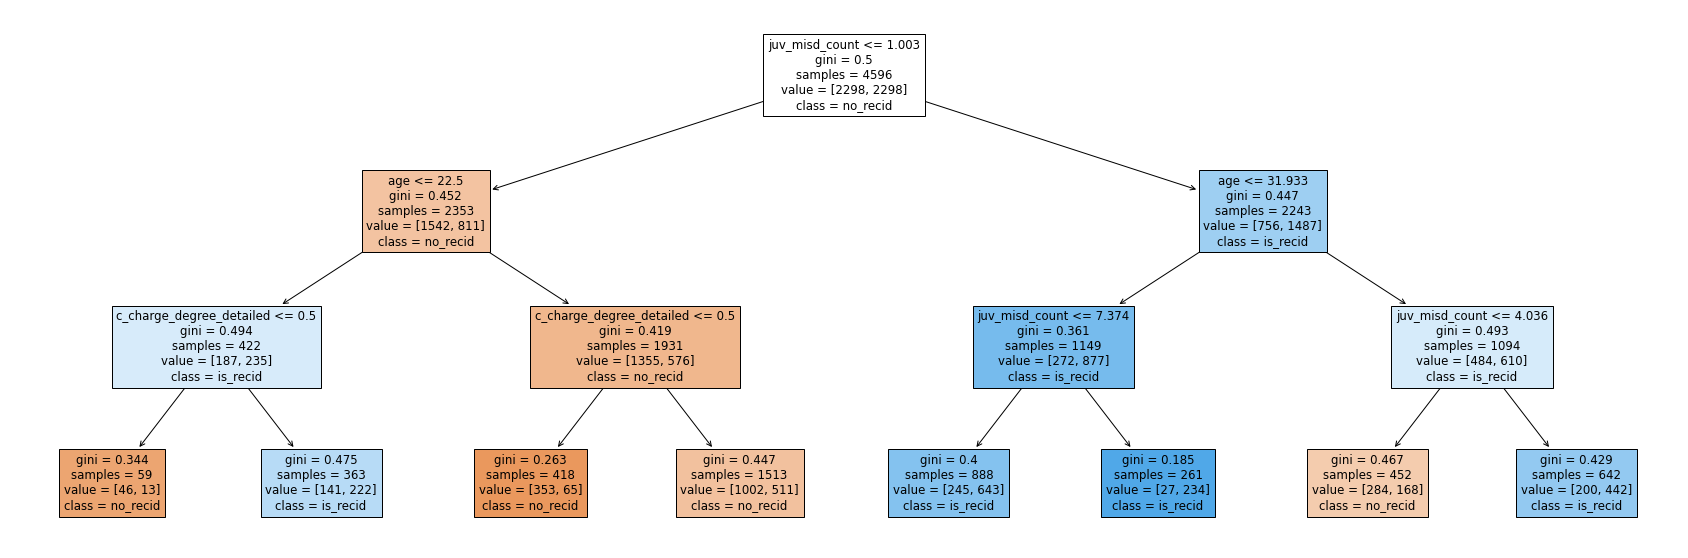

In [186]:
sns.reset_orig()
plt.figure(figsize=(30,10))
plot_tree(pipe_tree["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

When we initiate the Decision Tree Classifier, by-default the criterion parameters is set to ‘gini’. For the whole dataset, we obtain an accuracy score of 69% and ROC AUC 0.71

#### Subset

In [187]:
model_name = "Vanilla single Tree_Sub"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree_s = imblearn_make_pipeline(preproc_s, smt_s, tree) ##Create pipeline

In [188]:
cv_tree_s = cross_validate(pipe_tree_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [189]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree_s)

In [190]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree_s['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla single Tree_Sub: 0.67
10 fold cv ROC AUC score of Vanilla single Tree_Sub: 0.71


In [191]:
pipe_tree_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_tree_s

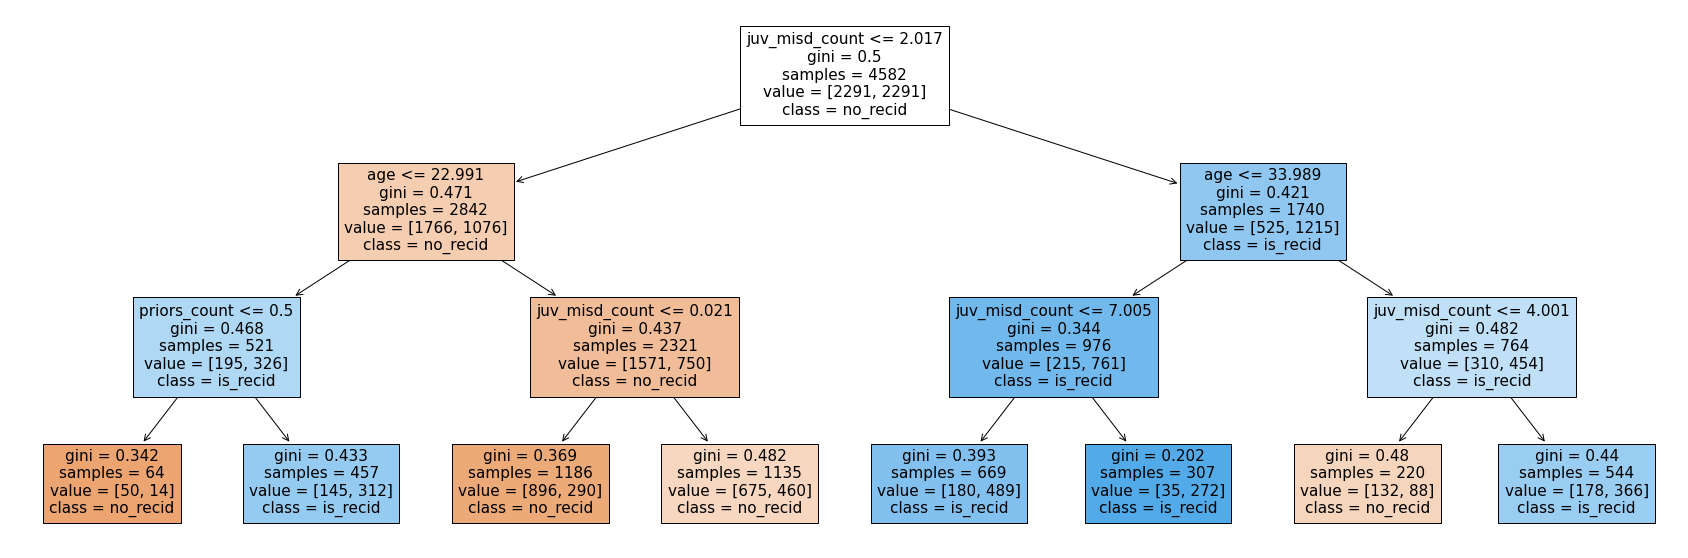

In [192]:
plt.figure(figsize=(30,10))
plot_tree(pipe_tree_s["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

While putting out some features such as "c_charge_degree" and "age_cat", we experience a reduction in the accuracy score by 2%, while ROC AUC stays the same.

#### Subset with race

In [193]:
model_name = "Vanilla single Tree_rSub"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree_rs = imblearn_make_pipeline(preproc_rs, smt_s, tree) ##Create pipeline

In [194]:
cv_tree_rs = cross_validate(pipe_tree_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

In [195]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree_rs)

In [196]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree_rs['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla single Tree_rSub: 0.68
10 fold cv ROC AUC score of Vanilla single Tree_rSub: 0.71


In [197]:
pipe_tree_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_tree_rs

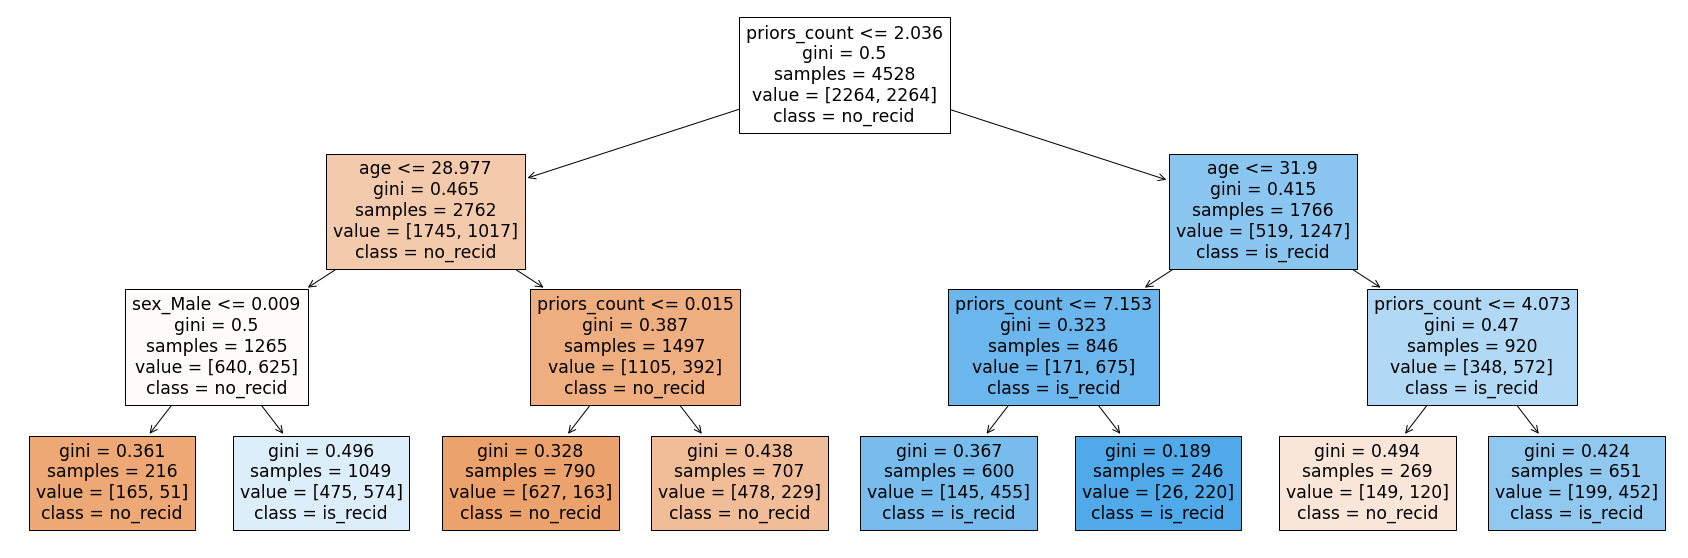

In [198]:
plt.figure(figsize=(30,10))
plot_tree(pipe_tree_rs["decisiontreeclassifier"], 
          feature_names=X_train_rsub_trans.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

With that same subset, added "race" as a feature, the accuracy score raises back to 69%, while ROC AUC slightly increases by 0.1, compared with the subsetl model without "race".

### Single hyperparameter-tuned tree

#### Complete Dataset

In [199]:
model_name = "Tuned single Tree"
tree = DecisionTreeClassifier()
pipe_tree = imblearn_make_pipeline(preproc, smt, tree) ##Create pipeline

In [200]:
#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

In [201]:
grid_tree_tuned = GridSearchCV(pipe_tree, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [202]:
#grid_tree_tuned.fit(X_train, y_train);

In [203]:
# #Save grid search results as .pkl file 
# joblib.dump(grid_tree_tuned, 'stored_models/grid_tree_tuned.pkl')

In [204]:
# Load best model .pkl file 
grid_tree_tuned = joblib.load('stored_models/grid_tree_tuned.pkl')

In [205]:
print(grid_tree_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned.best_score_, 2)}")

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 61, 'decisiontreeclassifier__min_samples_split': 6}
10 fold cv ROC AUC score of Tuned single Tree: 0.72


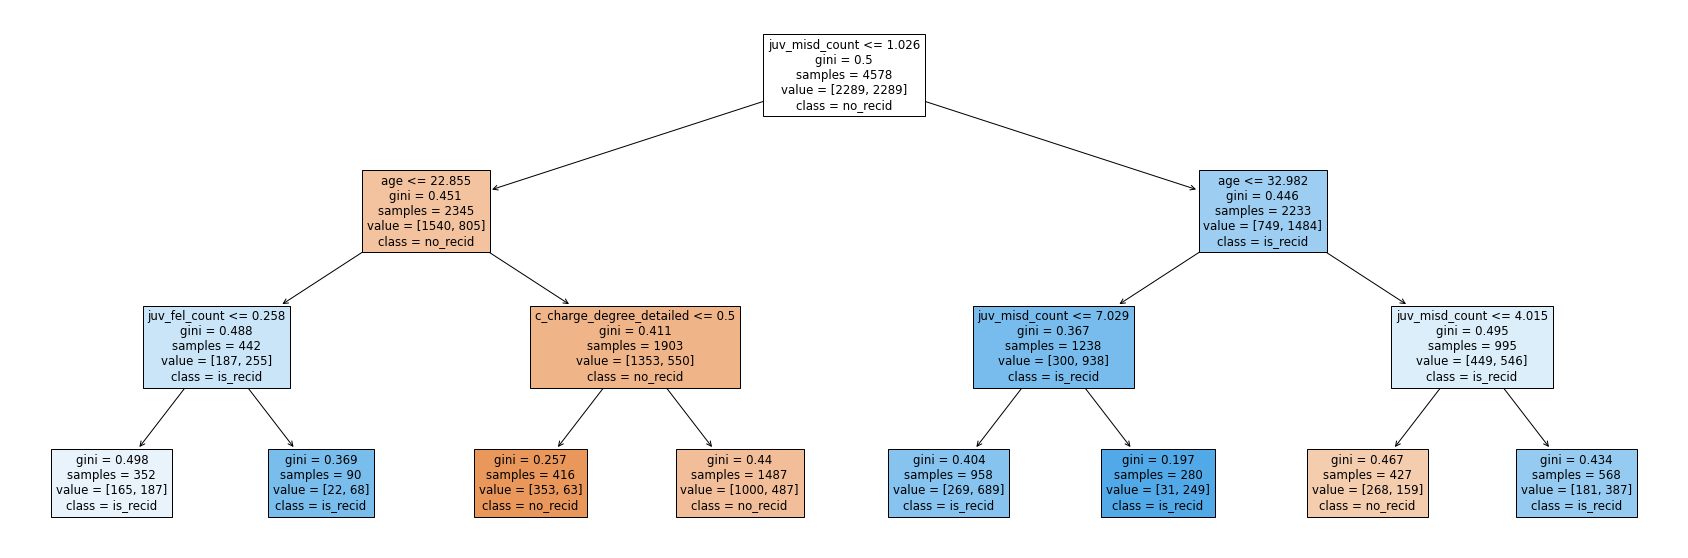

In [206]:
plt.figure(figsize=(30,10))
plot_tree(grid_tree_tuned.best_estimator_["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

After tuning the single "vanilla" tree, max_feature (the number of features to consider when looking for the best split) is chosen as n_features. Although, we obtain no change in ROC AUC score for the complete dataset compared to the untuned single tree model.

In [207]:
# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned)

#### Subset

In [208]:
model_name = "Tuned single Tree_Sub"
tree = DecisionTreeClassifier()
pipe_tree_s = imblearn_make_pipeline(preproc_s, smt_s, tree) ##Create pipeline

In [209]:
#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

In [210]:
grid_tree_tuned_s = GridSearchCV(pipe_tree_s, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [211]:
# grid_tree_tuned_s.fit(X_train, y_train);

In [212]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_tree_tuned_s, 'stored_models/grid_tree_tuned_s.pkl')

In [213]:
# Load best model .pkl file 
grid_tree_tuned_s = joblib.load('stored_models/grid_tree_tuned_s.pkl')

In [214]:
print(grid_tree_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned_s.best_score_, 2)}")

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 81, 'decisiontreeclassifier__min_samples_split': 6}
10 fold cv ROC AUC score of Tuned single Tree_Sub: 0.72


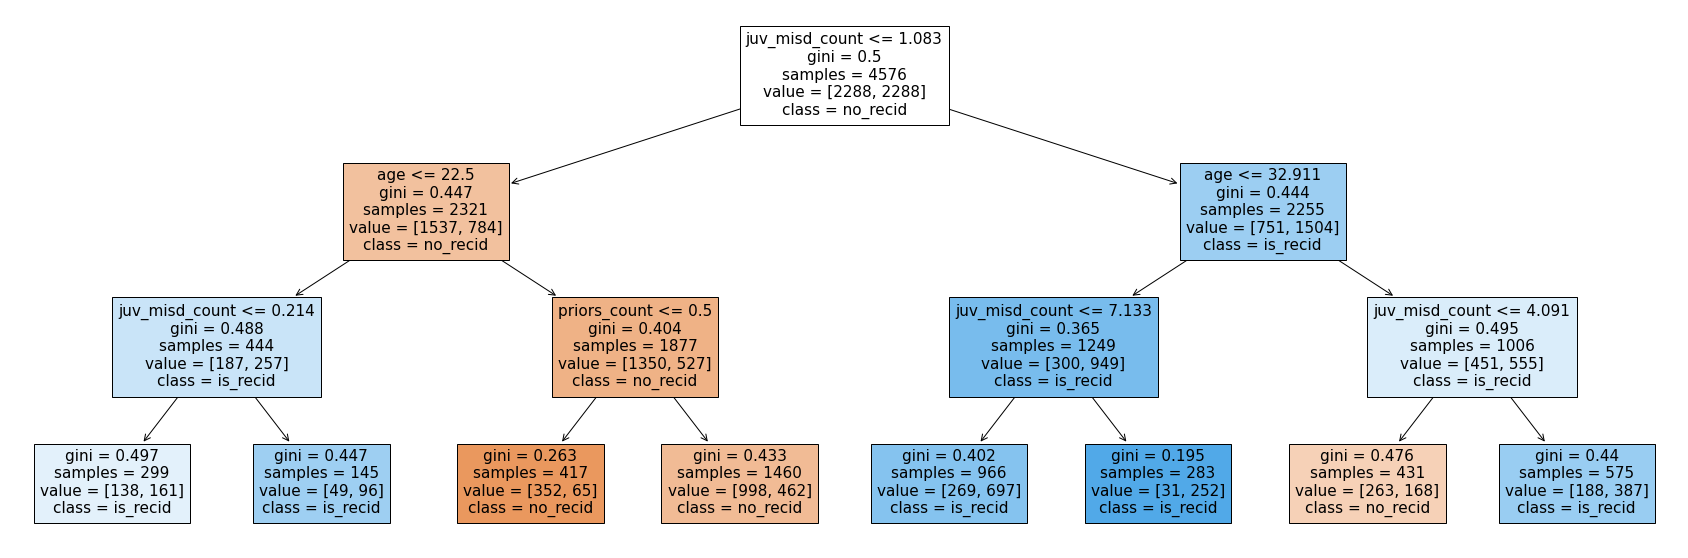

In [215]:
plt.figure(figsize=(30,10))
plot_tree(grid_tree_tuned_s.best_estimator_["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

With the same tuned number for max_depth, max_feature stays as n_features, ROC AUC increases slightly by 0.1 for the model with subset.

In [216]:
# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned_s)

#### Subset with race

In [217]:
model_name = "Tuned single Tree_rSub"
tree = DecisionTreeClassifier()
pipe_tree_rs = imblearn_make_pipeline(preproc_rs, smt_s, tree) ##Create pipeline

In [218]:
#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

In [219]:
grid_tree_tuned_rs = GridSearchCV(pipe_tree_rs, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [220]:
# grid_tree_tuned_rs.fit(X_train_race, y_train_race);

In [221]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_tree_tuned_rs, 'stored_models/grid_tree_tuned_rs.pkl')

In [222]:
# Load best model .pkl file 
grid_tree_tuned_rs = joblib.load('stored_models/grid_tree_tuned_rs.pkl')

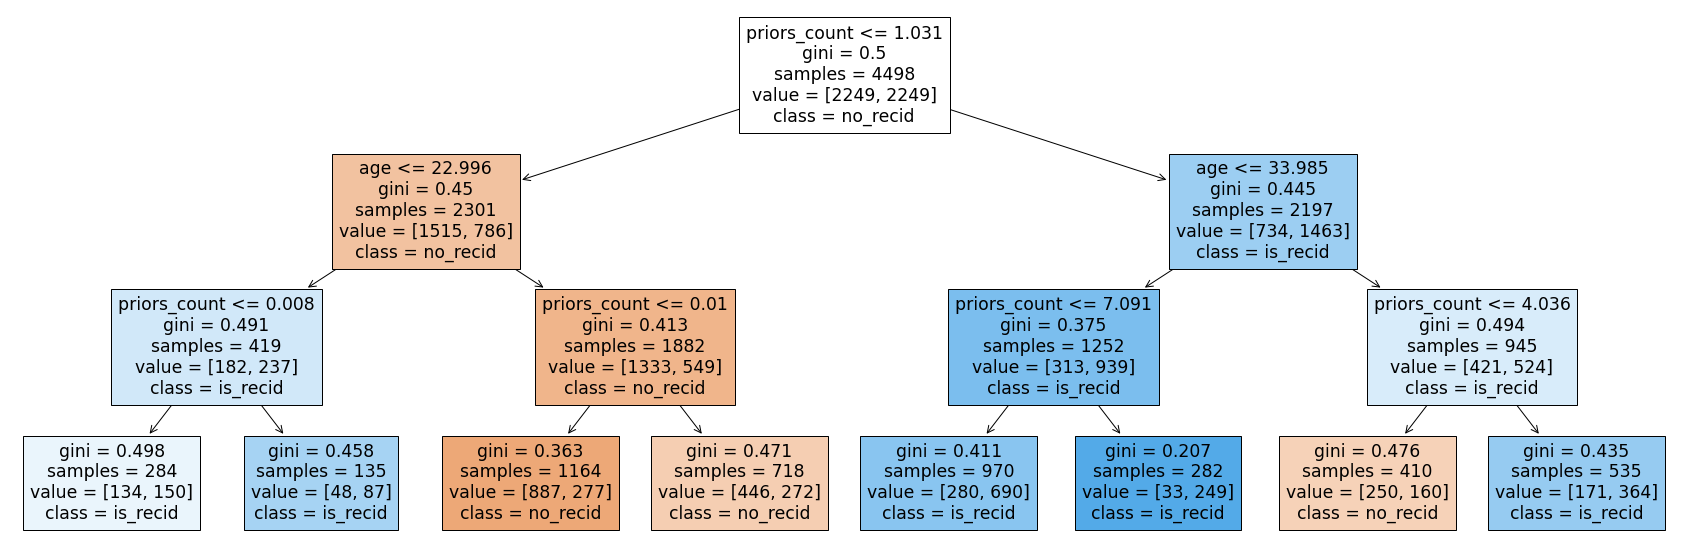

In [223]:
plt.figure(figsize=(30,10))
plot_tree(grid_tree_tuned_rs.best_estimator_["decisiontreeclassifier"], 
          feature_names=X_train_rsub_trans.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

In [224]:
print(grid_tree_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned_rs.best_score_, 2)}")

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 81, 'decisiontreeclassifier__min_samples_split': 10}
10 fold cv ROC AUC score of Tuned single Tree_rSub: 0.72


The tree model with "race" does not have any changes in ROC AUC after being tuned.

In [225]:
# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned_rs)

## Bagged Tuned Decision Tree

#### Complete Dataset

In [226]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old = grid_tree_tuned.best_params_
best_params_new = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old.items()}

In [227]:
model_name = "Bagged tuned single Tree"
base_estimator=DecisionTreeClassifier(**best_params_new) # Instantiate best model from gridsearch
bagged_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(**best_params_new), n_estimators=501)
pipe_bagtree = imblearn_make_pipeline(preproc, smt, bagged_tree) ##Create pipeline

In [228]:
#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [320],
               'baggingclassifier__max_samples': [0.5],
               'baggingclassifier__max_features': [0.6],
               'baggingclassifier__oob_score': [True]
               }

In [229]:
grid_bagtree = GridSearchCV(pipe_bagtree, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [230]:
# grid_bagtree.fit(X_train, y_train);

In [231]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_bagtree, 'stored_models/grid_bagtree.pkl')

In [232]:
# Load best model .pkl file 
grid_bagtree = joblib.load('stored_models/grid_bagtree.pkl')

In [233]:
print(grid_bagtree.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree.best_estimator_['baggingclassifier'].oob_score_,2)}")

{'baggingclassifier__max_features': 0.6, 'baggingclassifier__max_samples': 0.5, 'baggingclassifier__n_estimators': 320, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree: 0.73
ROC AUC score on OOB samples: 0.7


- For Bagging of tuned single tree on the complete dataset, after being tuned, we observe an increase in ROC AUC score compared to all the earlier models, namely 0.74.
- The number is a slightly lower on Out-of-bag sample, namely 0.71.

In [234]:
# Store trained model and cv_results
dict_models[model_name]=grid_bagtree.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree)

#### Subset

In [235]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old_s = grid_tree_tuned_s.best_params_
best_params_new_s = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old_s.items()}

In [236]:
model_name = "Bagged tuned single Tree_Sub"
base_estimator_s=DecisionTreeClassifier(**best_params_new_s) # Instantiate best model from gridsearch
bagged_tree_s = BaggingClassifier(base_estimator=base_estimator_s, n_estimators=501)
pipe_bagtree_s = imblearn_make_pipeline(preproc_s, smt_s, bagged_tree_s) ##Create pipeline

In [237]:
#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [250, 320, 370],
               'baggingclassifier__max_samples': [0.4,0.5,0.6],
               'baggingclassifier__max_features': [0.5,0.6,0.7,1],
               'baggingclassifier__oob_score': [True]
               }

In [238]:
grid_bagtree_s = GridSearchCV(pipe_bagtree_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [239]:
# grid_bagtree_s.fit(X_train, y_train);

In [240]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_bagtree_s, 'stored_models/grid_bagtree_s.pkl')

In [241]:
# Load best model .pkl file 
grid_bagtree_s = joblib.load('stored_models/grid_bagtree_s.pkl')

In [242]:
print(grid_bagtree_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree_s.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree_s.best_estimator_['baggingclassifier'].oob_score_,2)}")

{'baggingclassifier__max_features': 0.6, 'baggingclassifier__max_samples': 0.5, 'baggingclassifier__n_estimators': 250, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree_Sub: 0.74
ROC AUC score on OOB samples: 0.7


Instead of using the complete dataset, tuned model for the subset without race return the same ROC AUC for bagged tuned single tree, while the score on Out-of-bag sample decreases by 0.1.

In [243]:
# Store trained model and cv_results
dict_models[model_name]=grid_bagtree_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree_s)

#### Subset with race

In [244]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old_rs = grid_tree_tuned_rs.best_params_
best_params_new_rs = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old_rs.items()}

In [245]:
model_name = "Bagged tuned single Tree_rSub"
base_estimator_rs=DecisionTreeClassifier(**best_params_new_rs) # Instantiate best model from gridsearch
bagged_tree_rs = BaggingClassifier(base_estimator=base_estimator_rs, n_estimators=501)
pipe_bagtree_rs = imblearn_make_pipeline(preproc_rs, smt_s, bagged_tree_rs) ##Create pipeline

In [246]:
#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [250, 320, 370],
               'baggingclassifier__max_samples': [0.4,0.5,0.6],
               'baggingclassifier__max_features': [0.5,0.6,0.7,1],
               'baggingclassifier__oob_score': [True]
               }

In [247]:
grid_bagtree_rs = GridSearchCV(pipe_bagtree_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [248]:
# grid_bagtree_rs.fit(X_train_race, y_train_race);

In [249]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_bagtree_rs, 'stored_models/grid_bagtree_rs.pkl')

In [250]:
# Load best model .pkl file 
grid_bagtree_rs = joblib.load('stored_models/grid_bagtree_rs.pkl')

In [251]:
print(grid_bagtree_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree_rs.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_bagtree_rs.best_estimator_['baggingclassifier'].oob_score_,2)}")

{'baggingclassifier__max_features': 0.7, 'baggingclassifier__max_samples': 0.4, 'baggingclassifier__n_estimators': 250, 'baggingclassifier__oob_score': True}
10 fold cv ROC AUC score of Bagged tuned single Tree_rSub: 0.74
ROC AUC score on OOB samples: 0.71


While including "race" into our subset, we obtain the same result as on the complete featured dataset.

In [252]:
# Store trained model and cv_results
dict_models[model_name]=grid_bagtree_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree_rs)

## Random Forests

### Untuned Random Forest

#### Complete Dataset

In [253]:
model_name = "Vanilla random forest"
forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, forest) ##Create pipeline

In [254]:
cv_forest = cross_validate(pipe_forest, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [255]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla random forest: 0.64
10 fold cv ROC AUC score of Vanilla random forest: 0.66


In [256]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest)

In [257]:
pipe_forest.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_forest

Untuned random forest returns a less efficient model on complete train data compared to the single tree model earlier.

#### Subset

In [258]:
model_name = "Vanilla random forest_Sub"
forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, forest) ##Create pipeline

In [259]:
cv_forest_s = cross_validate(pipe_forest_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [260]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest_s['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla random forest_Sub: 0.64
10 fold cv ROC AUC score of Vanilla random forest_Sub: 0.66


The result stays the same for model with the filtered subset.

In [261]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest_s)

In [262]:
pipe_forest_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_forest_s

#### Subset with race

In [263]:
model_name = "Vanilla random forest_rSub"
forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_s, forest) ##Create pipeline

In [264]:
cv_forest_rs = cross_validate(pipe_forest_rs, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

In [265]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest_rs['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla random forest_rSub: 0.64
10 fold cv ROC AUC score of Vanilla random forest_rSub: 0.66


In [266]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest_rs)

In [267]:
pipe_forest_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_forest_rs

### Tuned Random Forest

#### Complete Dataset

In [268]:
model_name = "Tuned random forest"
forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, forest) ##Create pipeline

In [269]:
#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[500,750,1000],
               'randomforestclassifier__max_depth': np.arange(8,10,1), #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,45,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(82,90, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

In [270]:
grid_forest_tuned = RandomizedSearchCV(pipe_forest, param_grid, n_iter=100,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [271]:
# grid_forest_tuned.fit(X_train, y_train);

In [272]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_forest_tuned, 'stored_models/grid_forest_tuned.pkl')

In [273]:
# Load best model .pkl file 
grid_forest_tuned = joblib.load('stored_models/grid_forest_tuned.pkl')

In [274]:
print(grid_forest_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned.best_estimator_['randomforestclassifier'].oob_score_,2)}")

{'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__min_samples_leaf': 86, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': 9}
10 fold cv ROC AUC score of Tuned random forest: 0.74
ROC AUC score on OOB samples: 0.7


After adding "race" into our subset, we observe a decrease in accurary score and ROC AUC by 0.2 respectively.

In [275]:
# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned)

#### Subset

In [276]:
model_name = "Tuned random forest_Sub"
forest = RandomForestClassifier()
pipe_forest_s = imblearn_make_pipeline(preproc_s, smt_s, forest) ##Create pipeline

In [277]:
#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[1000],
               'randomforestclassifier__max_depth': [8], #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,40,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(82,85, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

In [278]:
grid_forest_tuned_s = GridSearchCV(pipe_forest_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [279]:
# grid_forest_tuned_s.fit(X_train, y_train);

In [280]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_forest_tuned_s, 'stored_models/grid_forest_tuned_s.pkl')

In [281]:
# Load best model .pkl file 
grid_forest_tuned_s = joblib.load('stored_models/grid_forest_tuned_s.pkl')

In [282]:
print(grid_forest_tuned_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned_s.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned_s.best_estimator_['randomforestclassifier'].oob_score_,2)}")

{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 84, 'randomforestclassifier__min_samples_split': 35, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__oob_score': True}
10 fold cv ROC AUC score of Tuned random forest_Sub: 0.74
ROC AUC score on OOB samples: 0.7


- After tuning the model on the complete train dataset, max_features is chosen as log2(n_features). Also, out-of-bag samples to estimate the generalization score were in used.
- The result returns a large increase compared with the untuned model on the same complete train dataset.

In [283]:
# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned_s)

#### Subset with race

In [284]:
model_name = "Tuned random forest_rSub"
forest = RandomForestClassifier()
pipe_forest_rs = imblearn_make_pipeline(preproc_rs, smt_s, forest) ##Create pipeline

In [285]:
#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[1000],
               'randomforestclassifier__max_depth': [8], #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,40,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(82,85, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

In [286]:
grid_forest_tuned_rs = GridSearchCV(pipe_forest_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [293]:
#grid_forest_tuned_rs.fit(X_train_race, y_train_race)

In [294]:
## Save grid search results as .pkl file 
# joblib.dump(grid_forest_tuned_rs, 'stored_models/grid_forest_tuned_rs.pkl')

['stored_models/grid_forest_tuned_rs.pkl']

In [295]:
# Load best model .pkl file 
grid_forest_tuned_rs = joblib.load('stored_models/grid_forest_tuned_rs.pkl')

In [297]:
print(grid_forest_tuned_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned_rs.best_score_, 2)}")
print(f"ROC AUC score on OOB samples: {np.round(grid_forest_tuned_rs.best_estimator_['randomforestclassifier'].oob_score_,2)}")

{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 82, 'randomforestclassifier__min_samples_split': 30, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__oob_score': True}
10 fold cv ROC AUC score of Tuned random forest_rSub: 0.74
ROC AUC score on OOB samples: 0.71


- Plugging "race" into the train subset, after being tuned, max_features is chosen as log2(n_features). Also, out-of-bag samples to estimate the generalization score were in used.
- The result returns a large increase compared with the untuned model on the same train subset.
- The result between 3 datasets (complete dataset, subset and subset without "race") are the same after being tuned

In [298]:
# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned_rs)

## XGB Boosting Classifier

### Untuned XGB Boosting Classifier

#### Complete Dataset 

In [299]:
model_name = "Untuned XGB"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB = imblearn_make_pipeline(preproc, smt, xgb_model) ##Create pipeline

In [300]:
cv_XGB = cross_validate(pipe_XGB, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [301]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Untuned XGB: 0.67
10 fold cv ROC AUC score of Untuned XGB: 0.68


In [302]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB)

In [303]:
pipe_XGB.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_XGB

The untuned XGBoost model returns higher accuracy score and ROC AUC score compared to the Random Forests one on the complete dataset.

#### Subset

In [304]:
model_name = "Untuned XGB_Sub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_s = imblearn_make_pipeline(preproc_s, smt_s, xgb_model) ##Create pipeline

In [305]:
cv_XGB_s = cross_validate(pipe_XGB_s, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [306]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB_s['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB_s['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Untuned XGB_Sub: 0.67
10 fold cv ROC AUC score of Untuned XGB_Sub: 0.69


In [307]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB_s)

In [308]:
pipe_XGB_s.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_XGB_s

The untuned XGBoost model also returns higher accuracy score and ROC AUC score compared to the Random Forests one on subset without "rac

#### Subset with race

In [309]:
model_name = "Untuned XGB_rSub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_rs = imblearn_make_pipeline(preproc_rs, smt_s, xgb_model) ##Create pipeline

In [310]:
cv_XGB_rs = cross_validate(pipe_XGB_s, X_train_race, y_train_race, scoring=clf_scoring, cv=10, n_jobs=-1)

In [311]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB_rs['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB_rs['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Untuned XGB_rSub: 0.67
10 fold cv ROC AUC score of Untuned XGB_rSub: 0.69


In [312]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB_rs)

In [313]:
pipe_XGB_rs.fit(X_train_race, y_train_race)

# Store trained model
dict_models[model_name]=pipe_XGB_rs

Before tuning, the subset with "race" included has the same result with the one without "race".

### Tuned XGB Boosting Classifier

#### Complete Dataset

In [314]:
model_name = "Tuned XGB"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB = imblearn_make_pipeline(preproc, smt, xgb_model) ##Create pipeline

In [315]:
# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[3,4,5], 
    'xgbclassifier__gamma':[i/10.0 for i in range(3,6)],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.5,0.7],
    'xgbclassifier__colsample_bytree':[0.8, 1], 
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [i/10.0 for i in range(3,5)],
    'xgbclassifier__learning_rate':[0.01,0.1,0.01],
    }

In [316]:
grid_XGB = RandomizedSearchCV(pipe_XGB, param_grid, n_iter=100,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [317]:
# grid_XGB.fit(X_train, y_train);

In [318]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_XGB, 'stored_models/grid_XGB.pkl')

In [319]:
# Load best model .pkl file 
grid_XGB = joblib.load('stored_models/grid_XGB.pkl')

In [320]:
print(grid_XGB.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB.best_score_, 2)}")

{'xgbclassifier__subsample': 0.5, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__n_estimators': 30, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 2, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__eta': 0.4, 'xgbclassifier__colsample_bytree': 1, 'xgbclassifier__booster': 'gbtree'}
10 fold cv ROC AUC score of Tuned XGB: 0.74


In [321]:
# Store trained model and cv_results
dict_models[model_name]=grid_XGB.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB)

After tuning on the complete train dataset, booster gbtree is used, we obtain an increase by 0.5 in ROC AUC compared to the untuned XGBoost model.

#### Subset

In [322]:
model_name = "Tuned XGB_Sub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_s = imblearn_make_pipeline(preproc_s, smt_s, xgb_model) ##Create pipeline

In [323]:
# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[3,4,5], 
    'xgbclassifier__gamma':[i/10.0 for i in range(3,6)],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.5,0.7],
    'xgbclassifier__colsample_bytree':[0.8, 1], 
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [i/10.0 for i in range(3,5)],
    'xgbclassifier__learning_rate':[0.01,0.1,0.01],
    }

In [324]:
grid_XGB_s = GridSearchCV(pipe_XGB_s, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [325]:
# grid_XGB_s.fit(X_train, y_train);

In [326]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_XGB_s, 'stored_models/grid_XGB_s.pkl')

In [327]:
# Load best model .pkl file 
grid_XGB_s = joblib.load('stored_models/grid_XGB_s.pkl')

In [328]:
print(grid_XGB_s.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB_s.best_score_, 2)}")

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__colsample_bytree': 1, 'xgbclassifier__eta': 0.3, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 30, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__subsample': 0.1}
10 fold cv ROC AUC score of Tuned XGB_Sub: 0.74


After tuning on the train subset without "race", booster gbtree is used, we also obtain an increase by 0.5 in ROC AUC compared to the untuned XGBoost model.

In [329]:
# Store trained model and cv_results
dict_models[model_name]=grid_XGB_s.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB_s)

#### Subset with race

In [330]:
model_name = "Tuned XGB_rSub"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB_rs = imblearn_make_pipeline(preproc_rs, smt_s, xgb_model) ##Create pipeline

In [331]:
# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[3,4,5], 
    'xgbclassifier__gamma':[i/10.0 for i in range(3,6)],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.5,0.7],
    'xgbclassifier__colsample_bytree':[0.8, 1], 
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [i/10.0 for i in range(3,5)],
    'xgbclassifier__learning_rate':[0.01,0.1,0.01],
    }

In [332]:
grid_XGB_rs = GridSearchCV(pipe_XGB_rs, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [333]:
# grid_XGB_rs.fit(X_train_race, y_train_race);

In [334]:
# # Save grid search results as .pkl file 
# joblib.dump(grid_XGB_rs, 'stored_models/grid_XGB_rs.pkl')

In [335]:
# Load best model .pkl file 
grid_XGB_rs = joblib.load('stored_models/grid_XGB_rs.pkl')

In [336]:
print(grid_XGB_rs.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB_rs.best_score_, 2)}")

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__colsample_bytree': 1, 'xgbclassifier__eta': 0.3, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__gamma': 0.5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 30, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__subsample': 0.1}
10 fold cv ROC AUC score of Tuned XGB_rSub: 0.74


- After tuning on the train subset with "race" included, booster gbtree is used, we obtain an increase by 0.5 in ROC AUC compared to the untuned XGBoost model.
- At the end, the 3 train datasets (complete dataset, subset without "race" and subset with "race") returns the same ROC AUC score of 0.74

In [337]:
# Store trained model and cv_results
dict_models[model_name]=grid_XGB_rs.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB_rs)

# Comparing results and choosing best model

## Compare cross validated metrics

In [338]:
# Transform cv-results 
cv_results_trans = save_cv_results(cv_results_list, cv_models_list)
grid_results_trans = save_grid_cv_results(grid_results_list, grid_models_list, clf_scoring)

cv_results_df = pd.concat(cv_results_trans+grid_results_trans, ignore_index=True)

cv_results_df_rSub = cv_results_df[cv_results_df['model'].str.contains('rSub')
                                   &(cv_results_df["model"].str.contains('Untuned')==False)]
cv_results_df_Sub = cv_results_df[(cv_results_df['model'].str.contains('_Sub'))
                                  &(cv_results_df["model"].str.contains('Untuned')==False)]

In [339]:
# Create df for plotting
cv_results_plots = pd.melt(cv_results_df, id_vars=['model'], var_name='metrics', value_name='values')

# Create df for plotting Sub
cv_results_plots_Sub = pd.melt(cv_results_df_Sub, id_vars=['model'], var_name='metrics', value_name='values')

# Create df for plotting rSub
cv_results_plots_rSub = pd.melt(cv_results_df_rSub, id_vars=['model'], var_name='metrics', value_name='values')

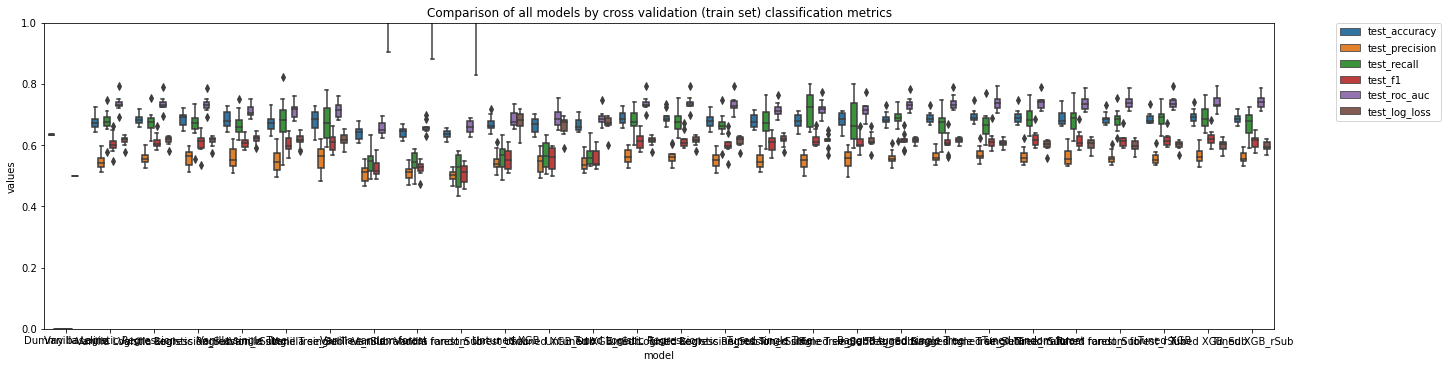

In [340]:
# Show results for all models
plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=cv_results_plots)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

- Since we trained so many different models we will have to create multiple diagrams to compare them.
- The one below shows all the model with our subset without "race" and also the "tuned" one.

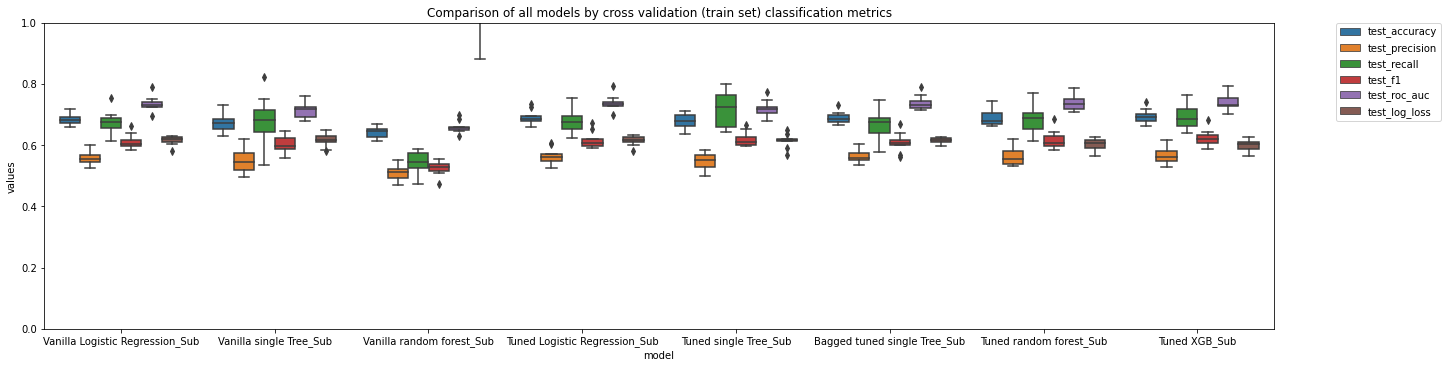

In [341]:
# Show results for all models Sub and tuned
plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=cv_results_plots_Sub)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

The one below gives an overview of model of subset with "race" included and also the tuned one.

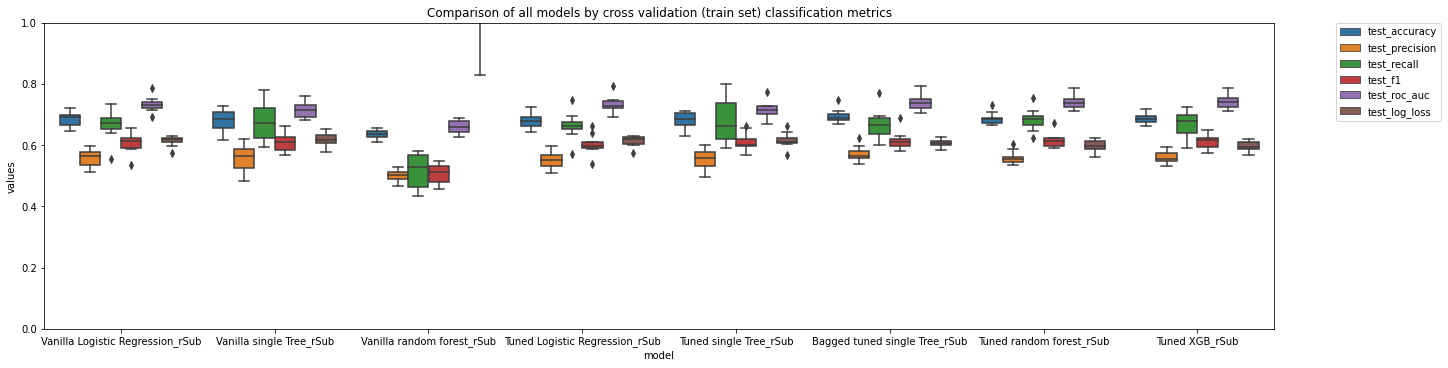

In [342]:
# Show results for all models rSub and tuned
plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=cv_results_plots_rSub)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

In [343]:
#tuned_compl_sub = cv_results_plots[(cv_results_plots["model"].str.contains('tuned|Tuned'))&
 #                              (~cv_results_plots["model"].str.contains('Vanilla')) &
  #                             (~cv_results_plots["model"].str.contains('Untuned'))]

#plt.figure(figsize=(20, 5), constrained_layout=True)
#sns.boxplot(x="model", y="values", hue="metrics", data=tuned_compl_sub)#, palette="Set3")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim(0,1)
#plt.title('Comparison of tuned models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

### Models trained on complete Dataset

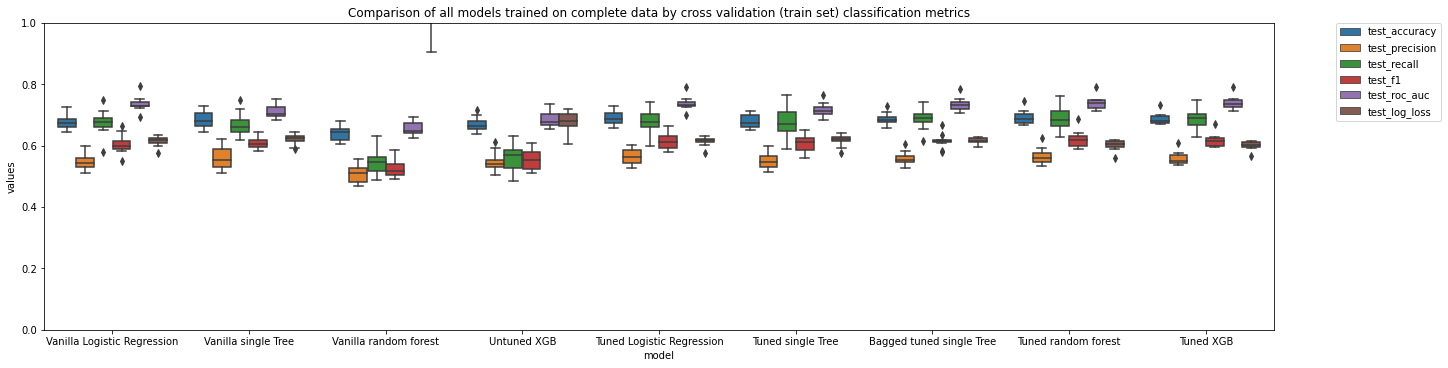

In [344]:
# Show results only for all models trained on complete dataset
all_compl = cv_results_plots[(cv_results_plots["model"].str.contains('Vanilla|tuned|Tuned'))&
                               (~cv_results_plots["model"].str.contains('_Sub'))&
                               (~cv_results_plots["model"].str.contains('_rSub'))] #new line for rSub

plt.figure(figsize=(20, 5), constrained_layout=True)
sns.boxplot(x="model", y="values", hue="metrics", data=all_compl)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models trained on complete data by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

Looking into the graph, we see that the tuned Logistic Regression, Bagged tuned single tree, Tuned Random Forest and Tuned XGB have more or less the same test_roc_auc (as also experienced in the previous part of model iteration)

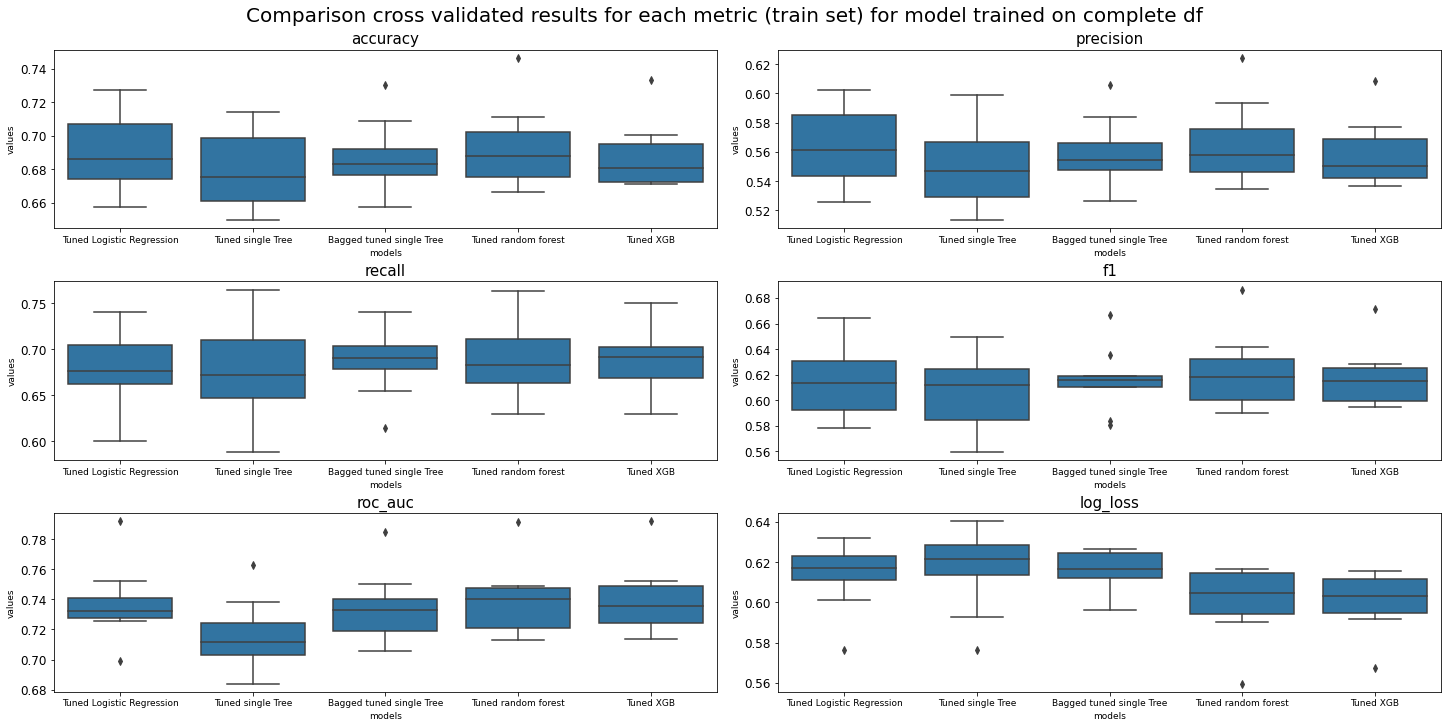

In [345]:
# Compare only tuned model on comp dataset
tuned_compl = cv_results_plots[(cv_results_plots["model"].str.contains('tuned|Tuned'))&
                               (~cv_results_plots["model"].str.contains('_Sub')) &
                               (~cv_results_plots["model"].str.contains('_rSub')) & #new line for rSub
                               (~cv_results_plots["model"].str.contains('Untuned'))]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for model trained on complete df', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(tuned_compl.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=tuned_compl[tuned_compl["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

- While comparing tuned model on the the complete train set, we obtain that the tuned random forest seems to have the highest accuracy score, precision and f1. High precision relates to a low false positive rate, which is more beneficial for people who are predicted wrongly as re-offenging but they did not. In this case, it will reduce the amount of those people who have to wait for a long time in the custody before the trial.
- At the same time, tuned single tree has the highest recall, and high recall relates to a low false negative rate. The low false negative rate indicates people who were predicted as would not re-offend, but they did. In this case, the high recall will reduce the risks of crime for the society.
- In terms of ROC AUC and log_loss, Tuned XGBoost seems to outperform the others.

### Models trained on subset


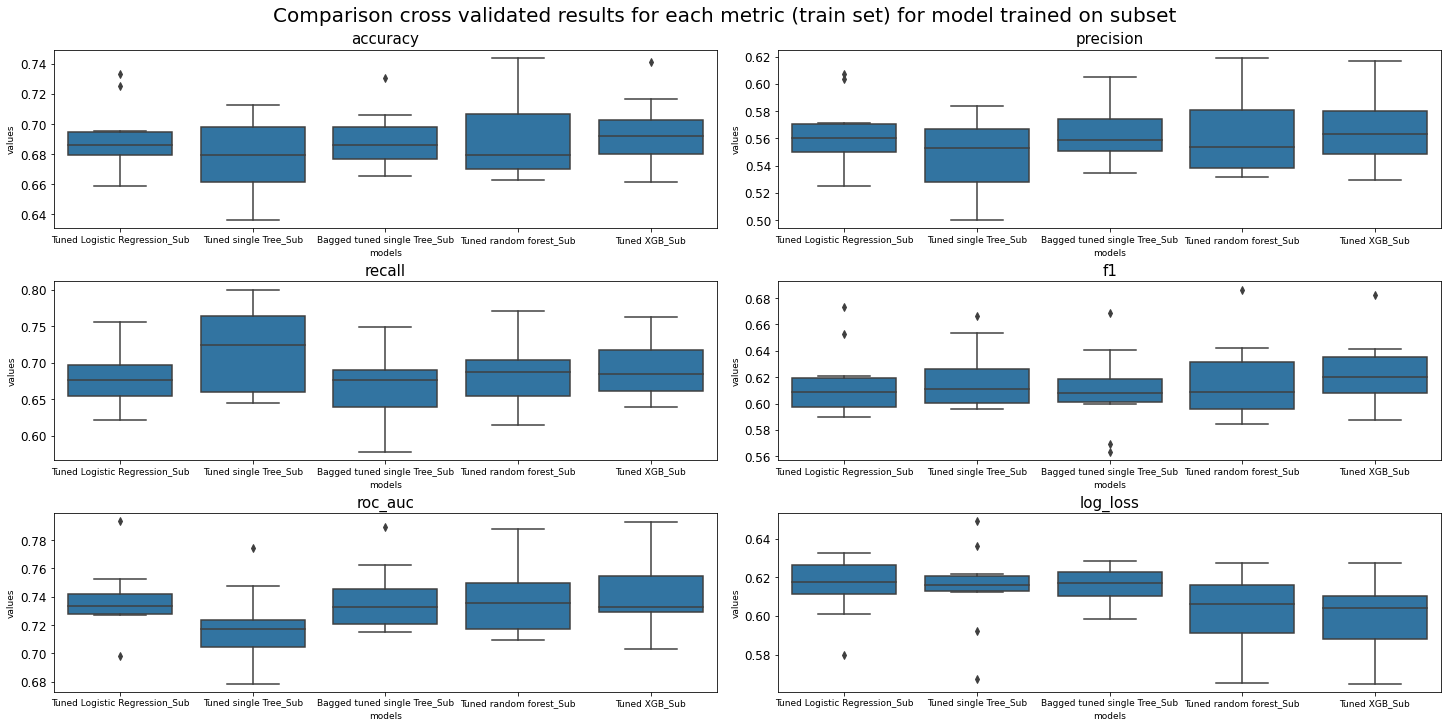

In [346]:
# Compare only tuned model on subset dataset
tuned_sub = cv_results_plots[(cv_results_plots["model"].str.contains('tuned|Tuned'))&
                               (cv_results_plots["model"].str.contains('_Sub')) &
                               (~cv_results_plots["model"].str.contains('Untuned'))]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for model trained on subset', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(tuned_sub.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=tuned_sub[tuned_sub["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

- While comparing tuned model on the train subset, we obtain that the tuned single tree seems to have the highest accuracy score, and precision and f1.
- At the same time, XGBoost has the highest recall and roc_auc. Also has the lowest log_loss.

### Models trained on subset with race

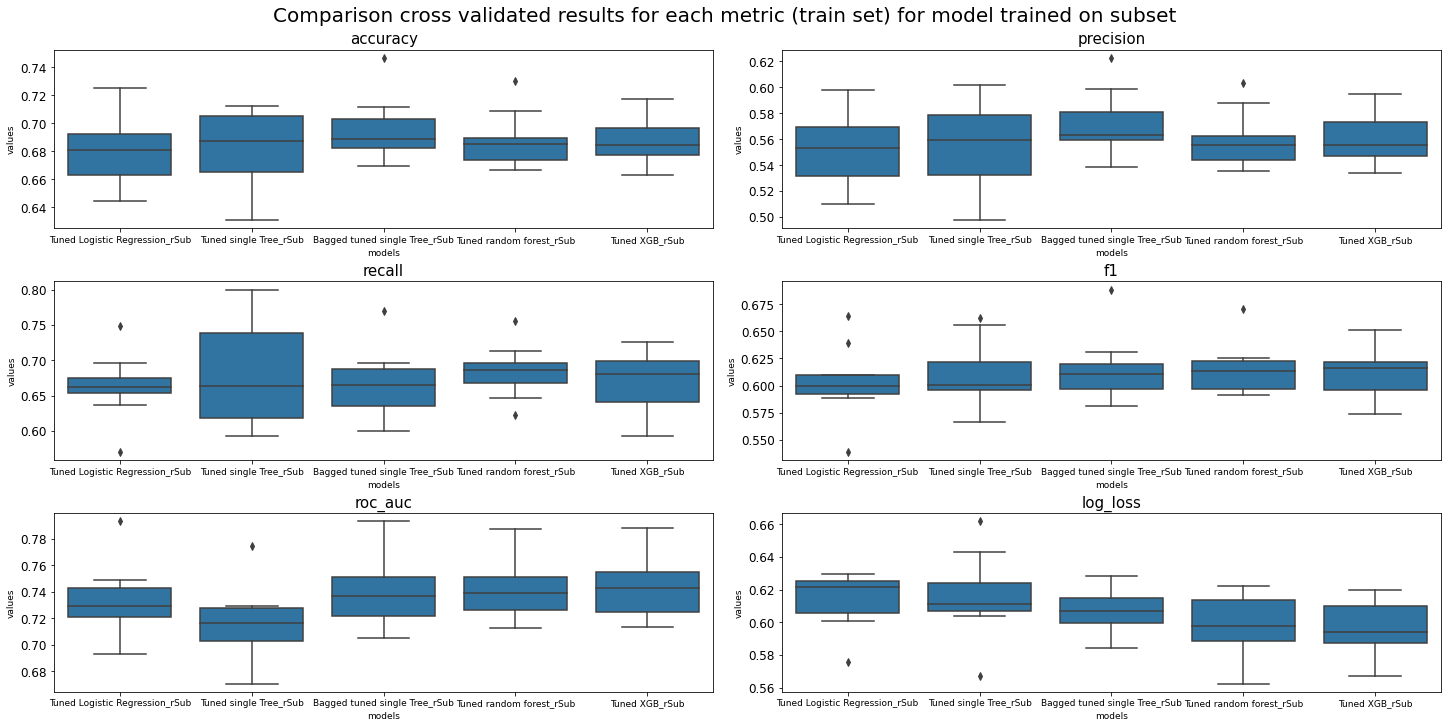

In [347]:
# Compare only tuned model on race subset dataset
tuned_sub = cv_results_plots[(cv_results_plots["model"].str.contains('tuned|Tuned'))&
                               (cv_results_plots["model"].str.contains('_rSub')) &
                               (~cv_results_plots["model"].str.contains('Untuned'))]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for model trained on subset', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(tuned_sub.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=tuned_sub[tuned_sub["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

- While comparing tuned model on the train subset with "race", again, we obtain that the tuned single tree seems to have the highest accuracy score, precision and f1.
- At the same time, Random Forest outperform on recall and roc_auc.
- XGBoost has the lowest log_loss.

### Side by side comparison for each model type 

In [348]:
log_reg_models = [model for model in dict_models.keys() if 'Logistic' in model]
tree_models = [model for model in dict_models.keys() if 'single Tree' in model]
forest_models = [model for model in dict_models.keys() if 'random forest' in model]
XGB_models = [model for model in dict_models.keys() if 'XGB' in model]

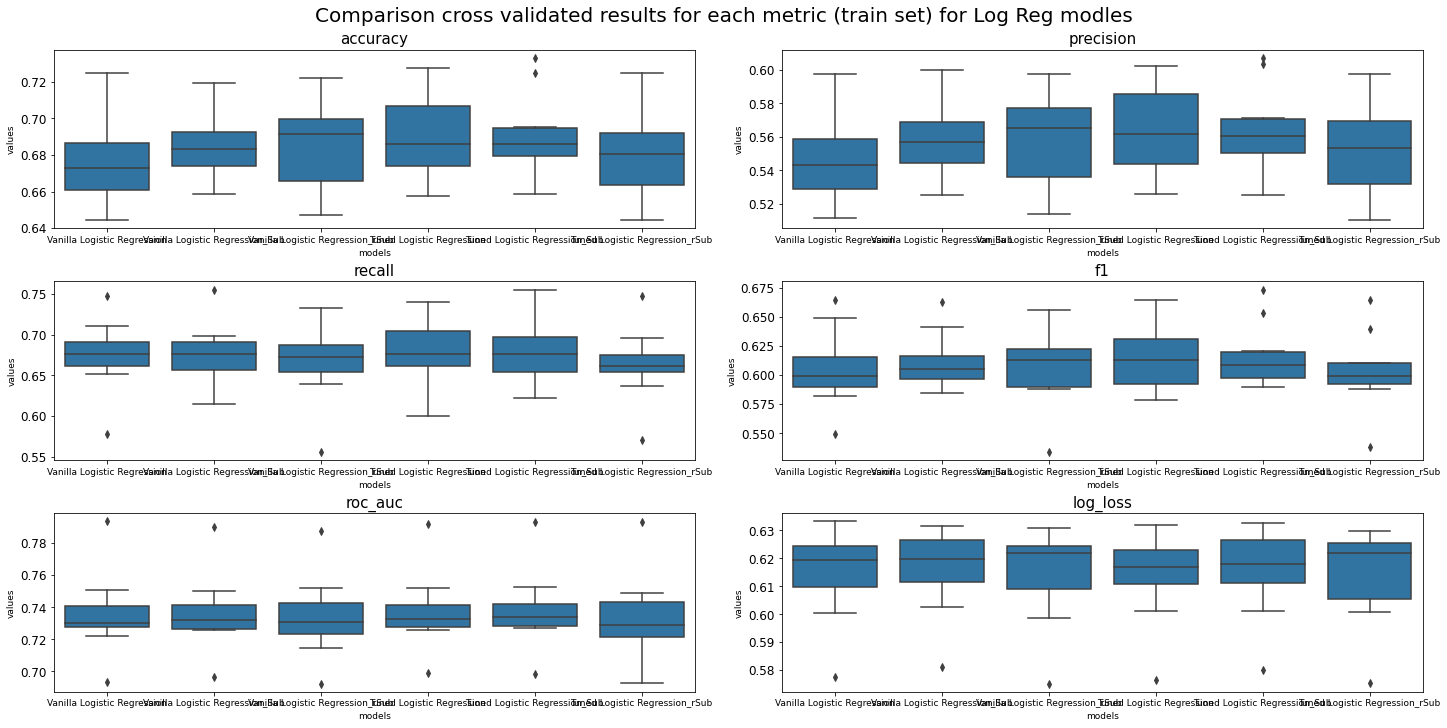

In [349]:
# Logistic Regression models
log_reg = cv_results_plots[cv_results_plots["model"].isin(log_reg_models)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for Log Reg modles', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(log_reg.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=log_reg[log_reg["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

While comparing between each type of model, we see that all the logistic model have more or less the same performance in most of the comparing criteria.

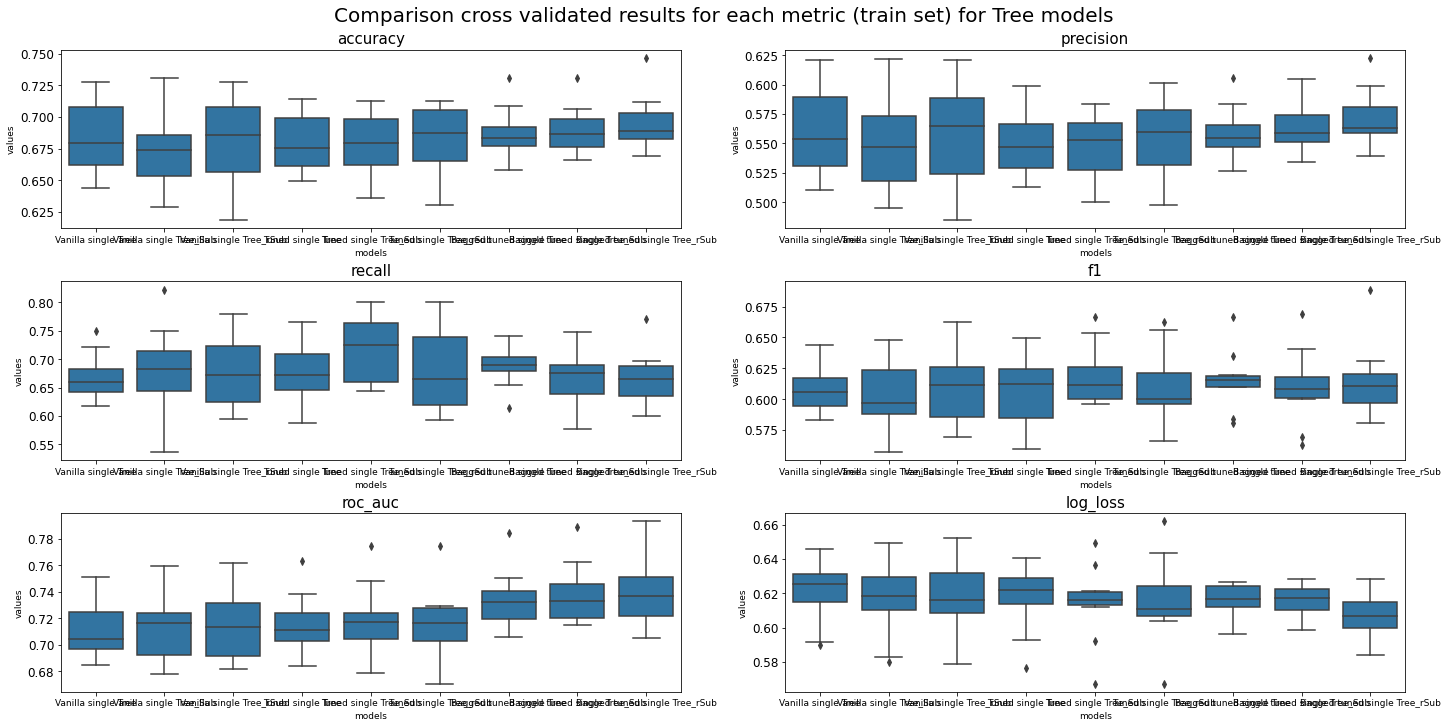

In [350]:
# Trees
trees = cv_results_plots[cv_results_plots["model"].isin(tree_models)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for Tree models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(trees.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=trees[trees["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

- In term of trees, tuned single tree model of the subset without "race" has the highest performance in accuracy, precision and f1.
- At the same time, vanilla single tree of the subset without "race" has roughly the highest in recall.
- Bagged single tree of the subset without "race" seems to outperform in roc_auc, while bagged single tree of the subset with "race" included has the lowest log_loss.

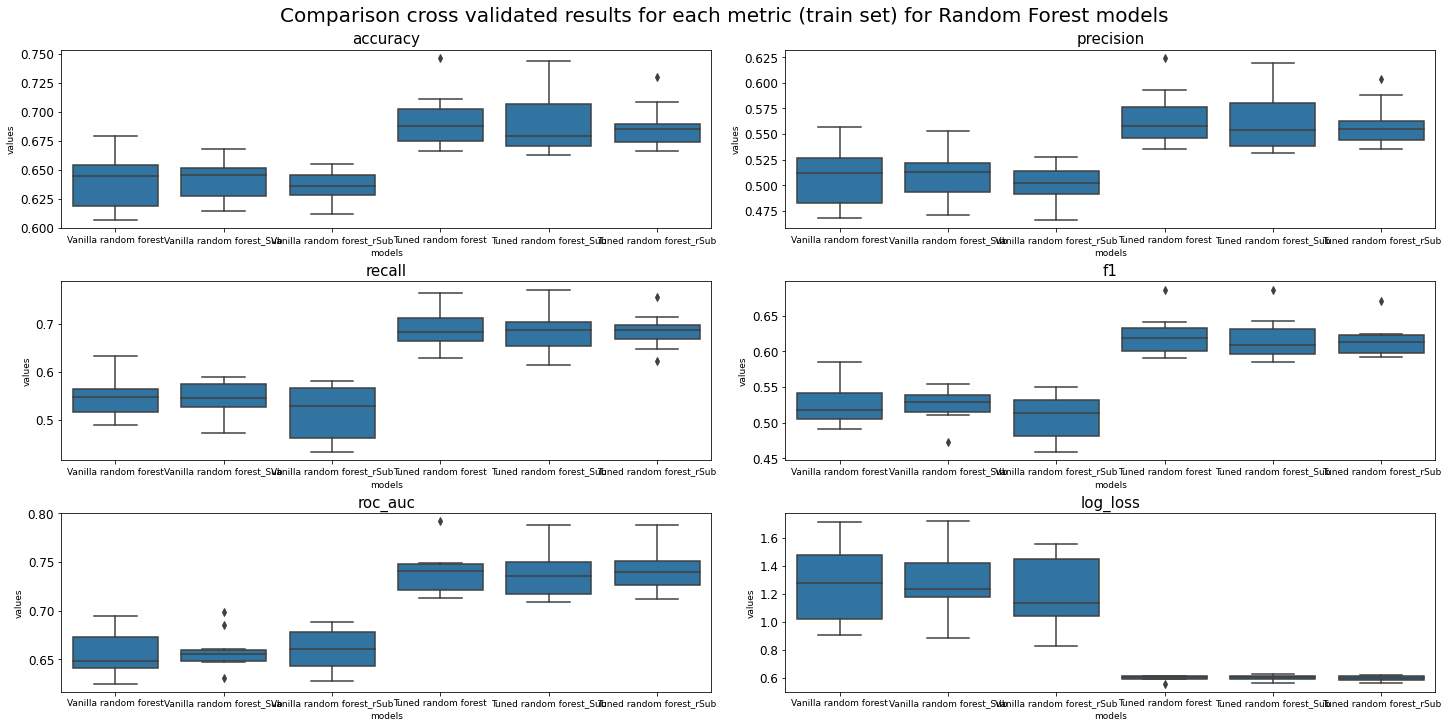

In [351]:
# Forest models
forests = cv_results_plots[cv_results_plots["model"].isin(forest_models)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for Random Forest models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(forests.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=forests[forests["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

- Looking into the forest, tuned random forest on the complete dataset has the highest performance in accuracy, precision and f1.
- At the same time, tuned random forest of the subset with "race" included has the highest recall and roc_auc, and also smalled log_loss.

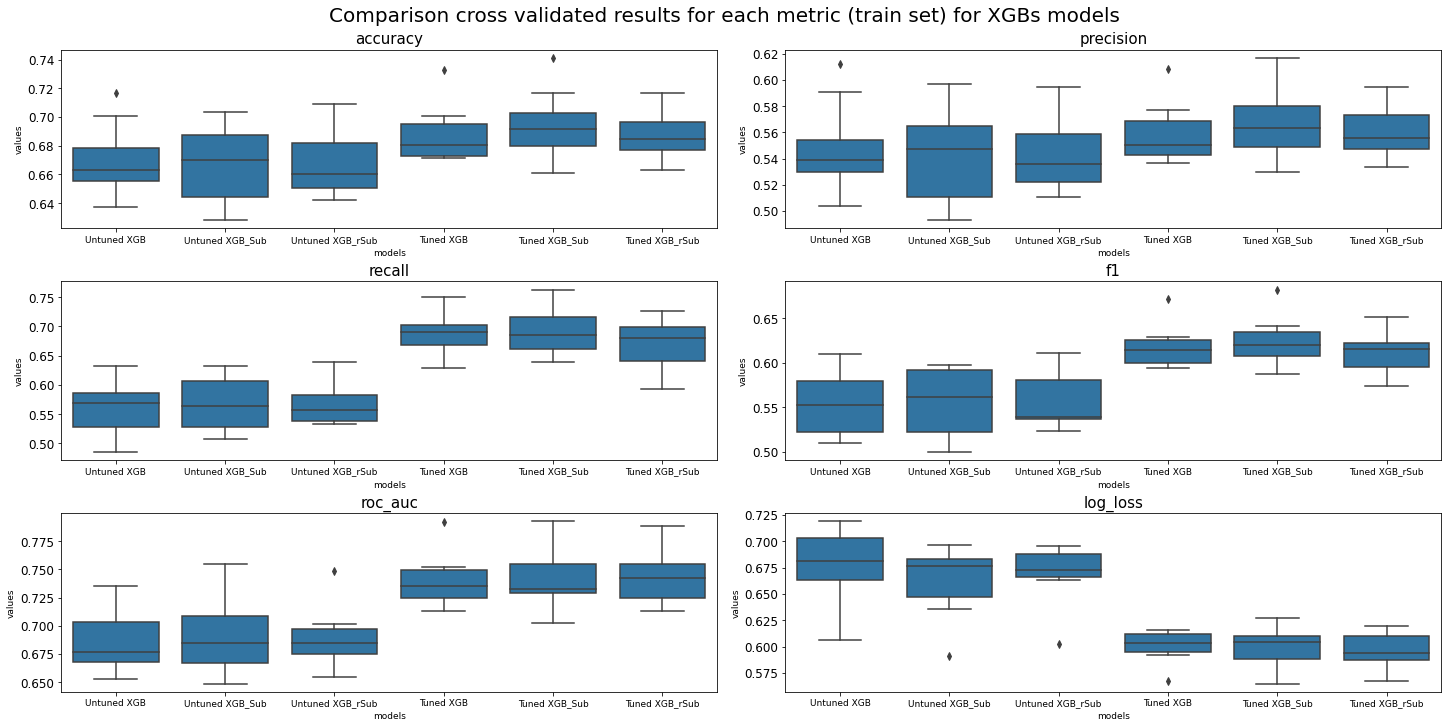

In [352]:
# XGB models
XGBs = cv_results_plots[cv_results_plots["model"].isin(XGB_models)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for XGBs models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(XGBs.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=XGBs[XGBs["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

- Regarding XGBoost, tuned XGBoost model on the complete dataset has the highest performance in accuracy.
- The tuned XGBoost model on the subset without "race" has the best recall, f1, roc_auc and also one of the models with the lowest log_loss
- Unpredictedly, untuned XGBoost model on that same subset has the highest precision.

#### Comparision best models subset

In [353]:
# Select best models and compare test scores
best_model_list = ["Tuned Logistic Regression_Sub", "Tuned single Tree_Sub", "Bagged tuned single Tree_Sub", "Tuned random forest_Sub", "Tuned XGB_Sub"]

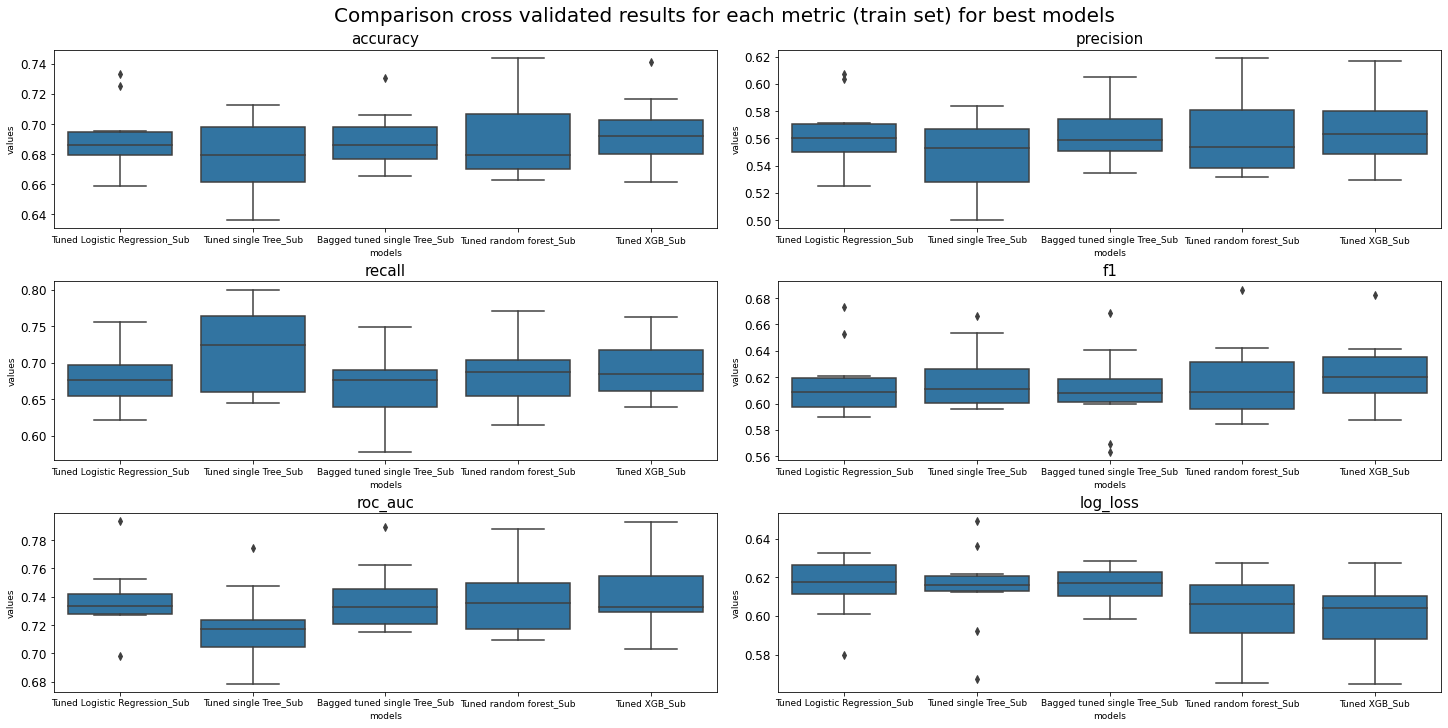

In [354]:
# best models
best_models = cv_results_plots[cv_results_plots["model"].isin(best_model_list)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for best models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(best_models.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=best_models[best_models["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

- The best models which were chosen out is the one on subset without "race". As in the above graph, we see XGBoost with the highest roc_auc, recall and lowest log_loss on our train set.
- At the same time, tuned single tree outperform in terms of accuracy, precision and f1.

#### Comparison best model with race subset

In [355]:
# Select best models and compare test scores
best_model_list_rSub = ["Tuned Logistic Regression_rSub", "Tuned single Tree_rSub", "Bagged tuned single Tree_rSub", "Tuned random forest_rSub", "Tuned XGB_rSub"]

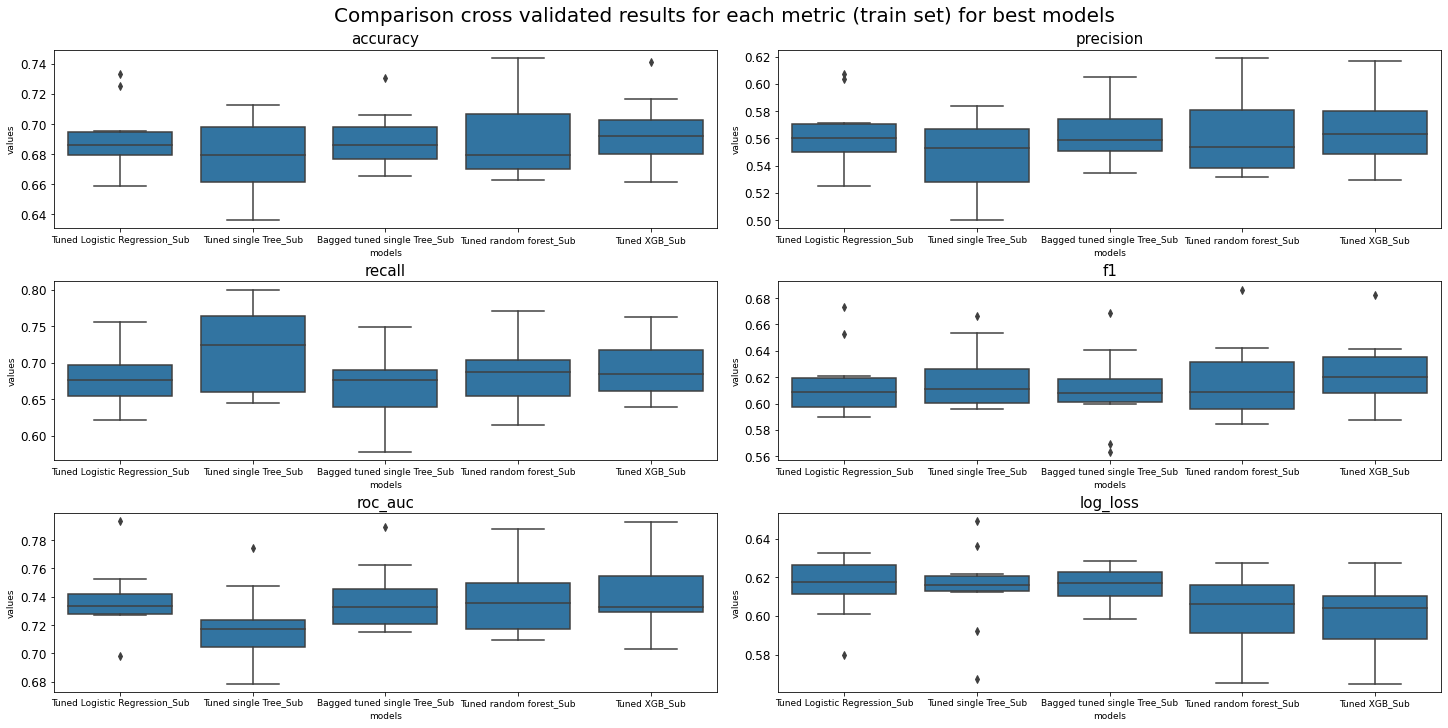

In [356]:
# best models
best_models_rSub = cv_results_plots[cv_results_plots["model"].isin(best_model_list_rSub)]

fig, ax = plt.subplots(3,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Comparison cross validated results for each metric (train set) for best models', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(best_models.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=best_models[best_models["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=15)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

-  As in the above graph, we see XGBoost with the highest roc_auc, recall and lowest log_loss on our train set of the subset with "race" included.
- At the same time, tuned single tree outperform in terms of accuracy, precision and f1.

## Calculate and compare test scores

### Models subset

In [357]:
# Select best models and compare test scores
# Filter df for best models
dict_best = {nk: dict_models[nk] for nk in best_model_list}

In [358]:
metrics_names = clf_scoring.copy()
metrics_names[-1]="log_loss"
test_metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss]
metrics_dict = dict(zip(metrics_names, test_metrics))

In [359]:
dict_test ={}
for me_name, metric in metrics_dict.items():
    test_scores = []
    for model in dict_best.values():
        if me_name=="log_loss":
            y_pred = model.predict_proba(X_test)
        else:
            y_pred = model.predict(X_test)
        test_scores.append(metric(y_test, y_pred))
    dict_test[me_name]=test_scores

In [360]:
test_scores_df = pd.DataFrame(dict_test, index=best_model_list)
test_scores_df

,accuracy,precision,recall,f1,roc_auc,log_loss
Tuned Logistic Regression_Sub,0.672111,0.546945,0.627350,0.584395,0.662732,0.611918
Tuned single Tree_Sub,0.675879,0.550512,0.642735,0.593060,0.668935,0.619937
Bagged tuned single Tree_Sub,0.672111,0.548686,0.606838,0.576299,0.658434,0.612645
Tuned random forest_Sub,0.680905,0.557377,0.639316,0.595541,0.672190,0.599227
Tuned XGB_Sub,0.670854,0.542069,0.671795,0.600000,0.671051,0.603462


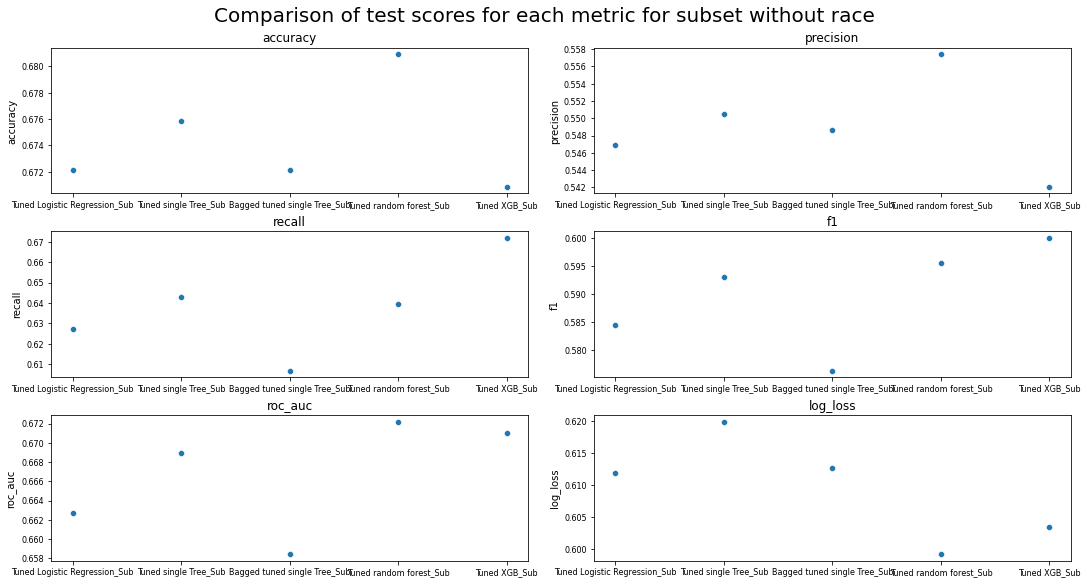

In [361]:
#
fig, ax = plt.subplots(3,2, figsize=(15,8), constrained_layout=True)
fig.suptitle('Comparison of test scores for each metric for subset without race', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(test_scores_df.columns):
    chart = sns.scatterplot(x=test_scores_df.index, y=metric, data=test_scores_df, ax=ax[i])    
    ax[i].tick_params(labelsize=8)
    ax[i].set_title(metric, fontsize=12)

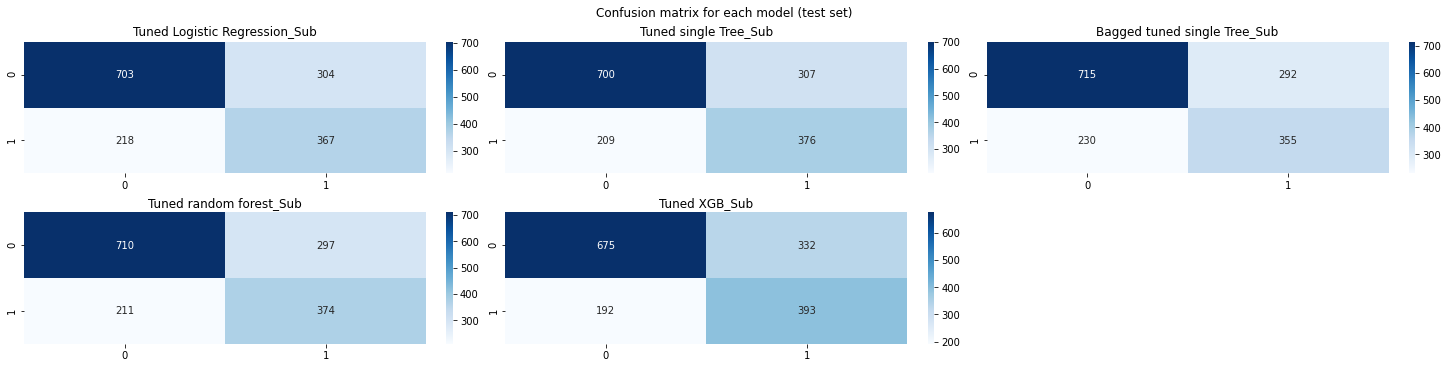

In [362]:
# confusion matrixes
fig, ax = plt.subplots(2,3, figsize=(20,5), constrained_layout=True)
fig.suptitle('Confusion matrix for each model (test set)')
ax = ax.ravel()
ax[-1].set_visible(False)
i=0

for name, model in dict_best.items():
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, ax=ax[i], fmt='d', cmap='Blues')
    ax[i].set_title(name, fontsize=12)
    i+=1

- After predicting on our test data for subset without "race", we observe the best accuracy score, precisions, roc_auc and log_loss with our XGBoost model.
- In the confusion matrix, we also see the mentioned XGBoost model with the highest number of true negatives. In terms of fairness, it is more fair to people who would not have to wait for more in custody before the trial.
- At the same time, tuned single tree has the highest true positive, false positive and also lowest false negative rate, which is one one hand more beneficial for the society while trying to eliminate the risk of crimes. But on the other hand, is not fair for people who did not re-offend but was predicted as would re-offend.


### Models with race subset

In [363]:
# Select best models and compare test scores
# Filter df for best models
dict_best = {nk: dict_models[nk] for nk in best_model_list_rSub} #rSub

In [364]:
metrics_names = clf_scoring.copy()
metrics_names[-1]="log_loss"
test_metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss]
metrics_dict = dict(zip(metrics_names, test_metrics))

In [365]:
dict_test ={}
for me_name, metric in metrics_dict.items():
    test_scores = []
    for model in dict_best.values():
        if me_name=="log_loss":
            y_pred_race = model.predict_proba(X_test_race)
        else:
            y_pred_race = model.predict(X_test_race)
        test_scores.append(metric(y_test_race, y_pred_race))
    dict_test[me_name]=test_scores

In [366]:
test_scores_df = pd.DataFrame(dict_test, index=best_model_list_rSub) #rSub
test_scores_df

,accuracy,precision,recall,f1,roc_auc,log_loss
Tuned Logistic Regression_rSub,0.659548,0.530935,0.630769,0.576563,0.653518,0.609370
Tuned single Tree_rSub,0.676508,0.549716,0.661538,0.600465,0.673371,0.618539
Bagged tuned single Tree_rSub,0.673367,0.550232,0.608547,0.577922,0.659785,0.607847
Tuned random forest_rSub,0.682161,0.557496,0.654701,0.602201,0.676407,0.596738
Tuned XGB_rSub,0.673367,0.546099,0.658120,0.596899,0.670172,0.595549


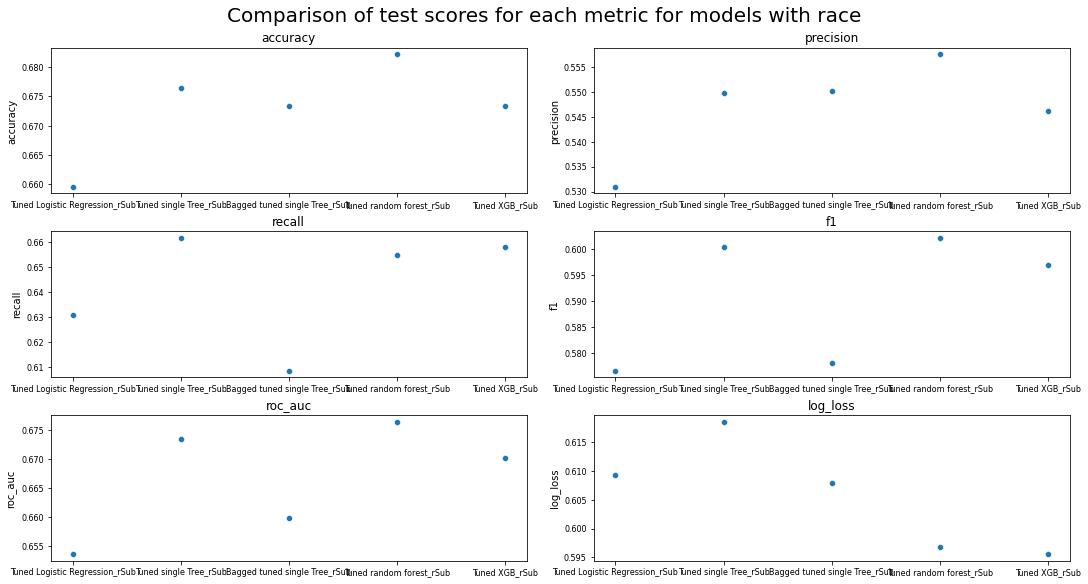

In [367]:
#
fig, ax = plt.subplots(3,2, figsize=(15,8), constrained_layout=True)
fig.suptitle('Comparison of test scores for each metric for models with race', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(test_scores_df.columns):
    chart = sns.scatterplot(x=test_scores_df.index, y=metric, data=test_scores_df, ax=ax[i])    
    ax[i].tick_params(labelsize=8)
    ax[i].set_title(metric, fontsize=12)

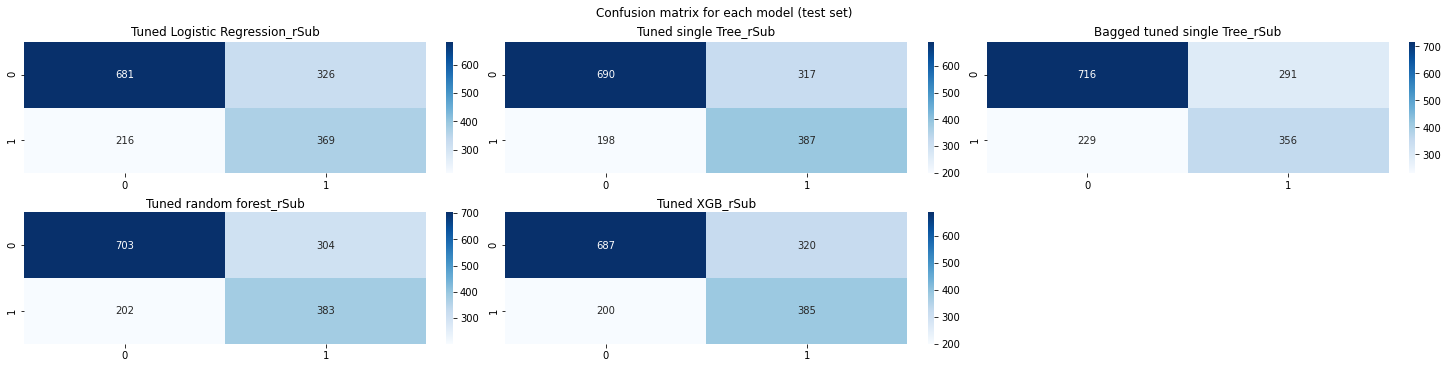

In [368]:
# confusion matrixes
fig, ax = plt.subplots(2,3, figsize=(20,5), constrained_layout=True)
fig.suptitle('Confusion matrix for each model (test set)')
ax = ax.ravel()
ax[-1].set_visible(False)
i=0

for name, model in dict_best.items():
    y_pred_race = model.predict(X_test_race) #race
    cf_matrix = confusion_matrix(y_test_race, y_pred_race)
    sns.heatmap(cf_matrix, annot=True, ax=ax[i], fmt='d', cmap='Blues')
    ax[i].set_title(name, fontsize=12)
    i+=1

- After predicting on our test data for subset with "race" included, we observe the best accuracy score, precisions, and f1 with our bagged tuned single tree.
- XGboost has the best recall and lowest log_loss.
- Tuned single tree has the best roc_auc,
- In the confusion matrix, we also see the mentioned tuned bagged single tree and tuned random forest with the highest number of true negatives. In terms of fairness, it is more fair to people who would not have to wait for more in custody before the trial.
- At the same time, tuned single tree and tuned XGBoost has the highest true positive, which is one one hand more beneficial for the society while trying to eliminate the risk of crimes.
- Tuned Logistic Regression has the highest false positive and false negative numbers.

## Choose best estimator

In [369]:
# Tuned XGB_sub as best estimator
best_estimator = dict_models["Tuned random forest_Sub"]
best_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               'M2',
                                                                                               'M1',
                                                                                               'F3',
                                                                                               'F2',
                                                                                               'F1']],
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  handle...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex'])])),
                ('smotetomek',
                 SMOTETomek(smote=SMOTENC(categorical_features=[5, 6]))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        min_samples_leaf=84,
                                        min_samples_split=35, n_estimators=1000,
                                        oob_score=True))])

# Explain best estimator

**Transform test data & reverse scaling for better interpretability**

- After considering those comparisions, we choose out XGBoost on the subset without "race" as our best estimator. We also want to exclude "race" for fairness.
- Here, we will explain our test subset.

In [370]:
#apply the preprocessing to X_test
X_test_trans = pd.DataFrame(preproc_s.transform(X_test), columns=column_nam_sub)
X_test_trans.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male
0,48.0,0.0,0.0,0.0,2.0,3.0,1.0
1,27.0,0.0,0.0,0.0,4.0,1.0,1.0
2,23.0,0.0,1.0,0.0,2.0,2.0,0.0


In [371]:
# #reverse scaling for better interpretability of diagrams
# X_test_unscaled = X_test_trans.copy()

# #numerical features
# X_test_unscaled[preproc_s.transformers_[0][2]]=preproc_s.transformers_[0][1][1].inverse_transform(X_test_trans[preproc_s.transformers_[0][2]])

# #ordinal features
# X_test_unscaled[preproc_s.transformers_[1][2]]=preproc_s.transformers_[1][1][2].inverse_transform(X_test_trans[preproc_s.transformers_[1][2]])

# X_test_unscaled.head(3)

---

**MDI feature importance**

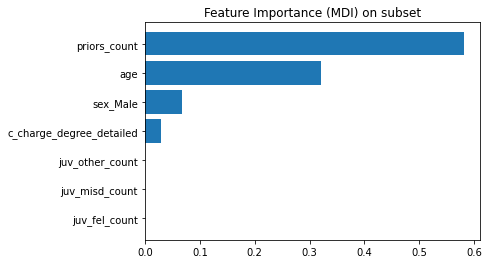

In [372]:
#Check feature importance of best model
feature_importance_s = best_estimator.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance_s)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance_s[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_sub_trans.columns)[sorted_idx])
plt.title("Feature Importance (MDI) on subset");


The MDI graph actually shows that our best model only chooses 5 out of 7 features.

## Shap values

In [373]:
#load JS vis in the notebook
shap.initjs() 

In [374]:
#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(best_estimator['randomforestclassifier'])

In [375]:
#get Shap values from preprocessed data
shap_values = explainer.shap_values(X_test_trans)

In [376]:
print(f"Shape of test data: {X_test_trans.shape}")
print(f"Shape of shap_values: {np.array(shap_values).shape}")

Shape of test data: (1592, 7)
Shape of shap_values: (2, 1592, 7)


For classification problems, `explainer.shap_values()` return a list of size n_classes. Since this is a binary classification model n_classes=2. Each object of this list is an array of size [n_samples, n_features] and corresponds to the SHAP values for the respective class. In this example, shap_values[1] is the SHAP values for the positive class (recid in next two years = Yes) & shap_values[0] is the SHAP values for the negative class. 

## Global interpretability

### Variable Importance Plot

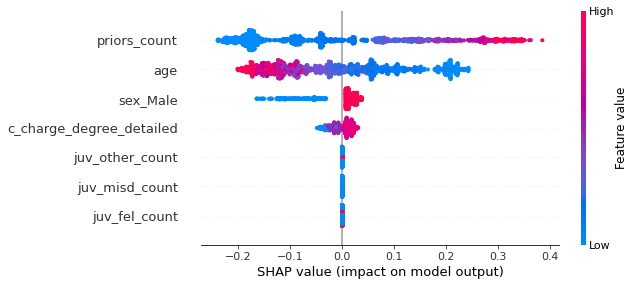

In [377]:
# Shap values
shap.summary_plot(shap_values[1], X_test_trans)

- The y-axis indicates the variable name, in order of importance from top to bottom. The model's most important feature is priors_count. This makes perfect sense, as the higher the prior number of arrests, the higher the chance that he will recide again. A high level of the "priors_count" content has a high and positive impact on the fact if the person will re-offend. The “high” comes from the red color, and the “positive” impact is shown on the X-axis.
- The second most important one is age. Just like the regression model, the lower the age the higher the chance the person will recide again. Tho, compared to "priors_count", "age"” is negatively correlated with the target variable.
- The third one is "c_charge_degree_datailed", which positively correlated with the target variable.
- On the 4th place is the gender feature. Males are predicted to have a higher chance of reciding.
- The model ignored the following feautures: "juv_misd_count", "juv_fel_count", 
- On the x-axis is the SHAP value. Indicates how much is the change in log-odds. From this number we can extract the probability.

### SHAP Partial Dependence Plot

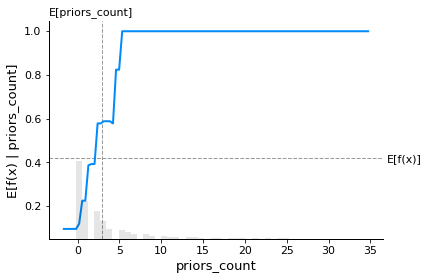

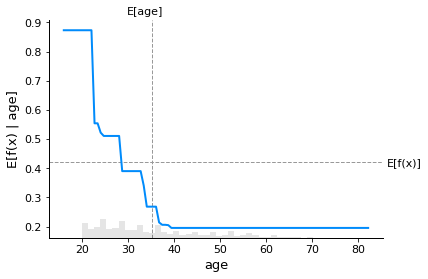

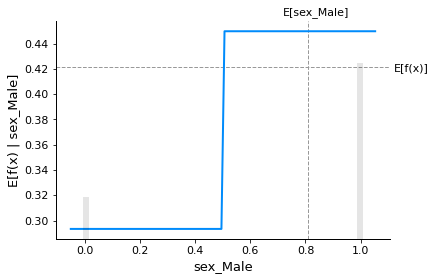

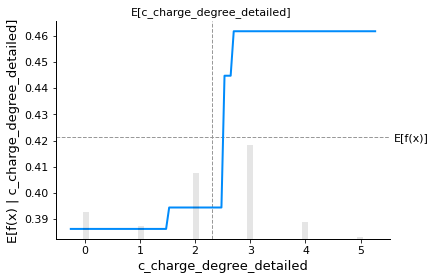

In [378]:
features_list = ["priors_count", "age", "sex_Male", "c_charge_degree_detailed"]
for i in features_list:
    shap.plots.partial_dependence(
    i, best_estimator['randomforestclassifier'].predict, X_test_trans.values, ice=False,
    model_expected_value=True, feature_expected_value=True, feature_names=X_test_trans.columns
    )

Here on the X-axis, we can see the histogram of the distribution of the data, and the blue line in the plot is the average value of the model output which passes through a centre point which is also the intersection point of the expected value lines. The distance from the blueline to the expected value E[f(x)] is the shap value.

In the plots, the behaviour of the model for the "priors_count", "sex_Male" and "c_charge_degree_detailed" is shown. 
- The prediction of a person who will recid increases when the "priors_count" increases. In another way, having more "priors_count" increases the odds of being labeled as reciding.
- Whereas for "age", an increase for this feature decreases the predicted probability of a person who will recid. Which also means that people who are older have better odds of not being labeled as reciding.
- Being a male also increases the odds of being labeled as re-offending.
- "c_charge_degree_detailed" also has positive impact to the prediction of a re-offending person.

### SHAP Dependence Plot

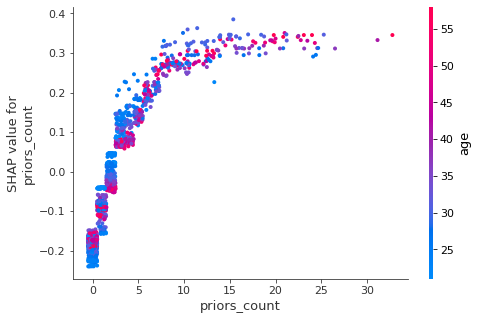

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


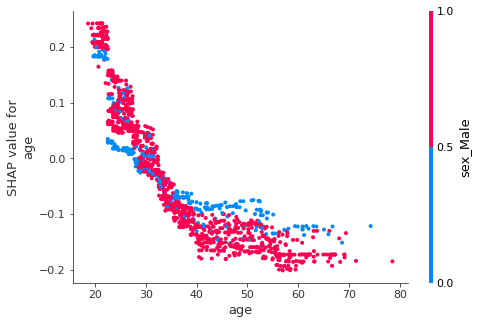

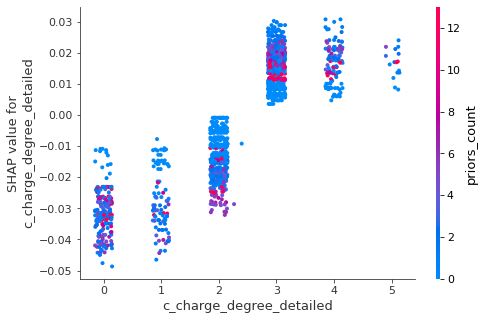

In [380]:
features_list = ["priors_count","age", "c_charge_degree_detailed"]

for i, feature in enumerate(features_list):
    shap.dependence_plot(feature, shap_values[1], X_test_trans, x_jitter=10)

The function automatically includes another variable that your chosen variable interacts most with.
- The first plot shows there is an non-linear and positive trend between "priors_count" and the target variable "age". So the older the person, the higher priors_count that person has, which does make much sense.
- The second plots shows there is a non-linear and negative trend between "age" and "sex_Male", and "age" interacts with "sex_Male" frequently.
- In the third plot, it also makes sense when a person with a higher "priors_count" has a higher "c_charge_degree_detailed".

## Local Interpretability

### Individual SHAP Value Plot

In [381]:
#Select random case from test data
np.random.seed(42)
rand_row = np.random.randint(0,X_test_trans.shape[0],1)
pd.concat([X_test_trans.iloc[rand_row,:],y_test[X_test_trans.iloc[rand_row,:].index]], axis=1)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
1126,25.0,0.0,0.0,0.0,0.0,2.0,1.0,0


In [382]:
shap.force_plot(explainer.expected_value[1], shap_values[1][rand_row[0],:], features=X_test_trans.iloc[rand_row,:])

- terms contributing to push the model output from the base value (the average model output over the training dataset we used) to the model output. Terms pushing the prediction to higher log-odds values are shown in red, those pushing the prediction to lower log-odds values are in blue.

- Note that SHAP values are log-odds when using XGBoost with the logistic objective function. To convert log-odds margin to probability, we can use the formula odds = exp(log-odds) from which, p = odds/(1+odds).

In [383]:
# Try understanding explainer.expected_value
j = rand_row[0]
log_odds = np.sum(shap_values[1][j])
avg_model_output = explainer.expected_value[1] #best_estimator.predict_proba(X_train)[:,1].mean() # prob
log_odds_avg_model_output = np.log(avg_model_output/(1-avg_model_output))
predicted_prob = best_estimator.predict_proba(X_test)[j][1] #target=1
predicted_log_odds = np.log(predicted_prob/(1-predicted_prob))
print("j:", j)
print("Sum of Shaphley values (log-odds) for j-instance:", log_odds, 
       'prob:', np.exp(log_odds)/(1.0+np.exp(log_odds)))
print("Average model output (Prob):", avg_model_output)
print("Predicted probability value for j-instance:", predicted_prob,
      "Predicted value:", best_estimator.predict(X_test)[j])
print('Shapley log_odds:', log_odds, 'is expected to be equal to pred-expected:', predicted_log_odds-explainer.expected_value[1])
print('pred-expected (prob):', explainer.expected_value[1])


j: 1126
Sum of Shaphley values (log-odds) for j-instance: -0.12351146346921749 prob: 0.4691613280401303
Average model output (Prob): 0.49975249891351614
Predicted probability value for j-instance: 0.3762410354442976 Predicted value: 0
Shapley log_odds: -0.12351146346921749 is expected to be equal to pred-expected: -1.0052865281915853
pred-expected (prob): 0.49975249891351614


In [384]:
# Check multiple samples (first 100 cases) at once
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], features=X_test_trans.iloc[:100,:])

Let's look at some special cases form the forceplot and compare them with the truth

In [385]:
ind= 18 # chosen basedn on multiple sample plot
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
18,56.0,0.0,0.0,0.0,9.0,0.0,1.0,0


- The output value 0.24 is the log odds for that observation.
- The base value -0.02033 is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction of mean(y_output). 
- "Priors_count" has a positive impact on the recid prediction. 
- "Age" and "c_charge_degree_detailed" has a negative impact on the predicted value and drives the prediction to the right.

In [386]:
ind= 78 # chosen basedn on multiple sample plot
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
78,28.0,0.0,2.0,0.0,21.0,3.0,1.0,0


In this example, all "Priors_count", "sex", "age", and high "c_charge_degree_detailed" has a positive impact on the recid prediction. 

In [387]:
ind= 39 # chosen basedn on multiple sample plot
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
39,24.0,0.0,0.0,0.0,8.0,3.0,1.0,0


Same as the one which is explained above

In [388]:
ind= 96 # chosen basedn on multiple sample plot
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
96,62.0,0.0,0.0,0.0,0.0,3.0,1.0,0


- A low "Priors_count" and high "age" have a negative impact on the recid prediction. 
- A high "c_charge_degree_detailed" has a postive impact on the predicted value and drives the prediction to the left.

In [389]:
ind= 11 # chosen basedn on multiple sample plot
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
11,41.0,0.0,0.0,0.0,4.0,2.0,1.0,1


- A high "Priors_count" and being Male have a positive impact on the recid prediction. 
- "c_charge_degree_detailed" and high "age" and low "juv_other_count" have a negative impact on the predicted value and drives the prediction to the left.

In [390]:
ind= 20 # chosen basedn on multiple sample plot
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
20,42.0,0.0,0.0,0.0,3.0,3.0,1.0,1


In [391]:
ind= 34 # chosen basedn on multiple sample plot
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
34,69.0,0.0,0.0,0.0,22.0,1.0,1.0,0


- A very high "Priors_count" and has a positive impact on the recid prediction. 
- A low "c_charge_degree_detailed" and high "age" have a negative impact on the predicted value and drives the prediction to the left.

In [392]:
ind= 1362 # chosen basedn on max juv_misd count
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
1362,37.0,1.0,8.0,5.0,23.0,4.0,1.0,1


- A very high "Priors_count", high "juv_other_count" and "c_charge_degree_detailed have a big positive impact on the recid prediction. 
- "Age" of 37 have a negative impact on the predicted value and helps reduce the log odds of being predicted and re-offending.

In [393]:
ind= 342 # chosen basedn on max juv_fel count
display(pd.concat([X_test_trans,y_test.reset_index(drop=True)], axis=1).loc[[ind]])
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], features=X_test_trans.iloc[ind,:])

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_detailed,sex_Male,two_year_recid
342,36.0,10.0,0.0,0.0,14.0,3.0,1.0,1


- A very high "Priors_count", and  "c_charge_degree_detailed have a big positive impact on the recid prediction. 
- "Age" of 36 have a negative impact on the predicted value and helps reduce the log odds of being predicted and re-offending.

# Fairness discussion